In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns
import pyro
import seaborn as sns

C:\Users\Kobo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# for each country and year change the life expectancy to the difference between life expectancy of this and the next year
import time
data = pd.read_csv("Data/Data_processed.csv", sep=';')

for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # transform data to look at differences from year to year for all nummerical features (2 first columns are country and continent)
    d.iloc[:,5:] = d.iloc[:,5:].diff()
    # replace nan values with 0
    d = d.fillna(0)
    data[data['Country'] == country] = d

data['Life expectancy difference'] = 0
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy '].diff()

    # replace nan values with 0
    d['Life expectancy difference'] = d['Life expectancy difference'].fillna(0)
    # replace old values with new values
    data[data['Country'] == country] = d


In [25]:

# create a new column to store difference in life expectancy for 1, 2 and 3 years in the past
data['Life expectancy difference 1 year ago'] = 0
data['Life expectancy difference 2 years ago'] = 0
# get difference in life expectancy for each country and year
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy difference'].shift(-1)
    d['Life expectancy difference 1 year ago'] = d['Life expectancy difference'].shift(1)
    d['Life expectancy difference 2 years ago'] = d['Life expectancy difference'].shift(2)
    # replace nan values with 0
    d['Life expectancy difference'] = d['Life expectancy difference'].fillna(0)
    d['Life expectancy difference 1 year ago'] = d['Life expectancy difference 1 year ago'].fillna(0)
    d['Life expectancy difference 2 years ago'] = d['Life expectancy difference 2 years ago'].fillna(0)
    # replace old values with new values
    data[data['Country'] == country] = d

C:\Users\Kobo\AppData\Local\Temp\ipykernel_8064\1816218023.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split[col] = (train_split[col] - mean) / std
C:\Users\Kobo\AppData\Local\Temp\ipykernel_8064\1816218023.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_split[col] = (val_split[col] - mean) / std


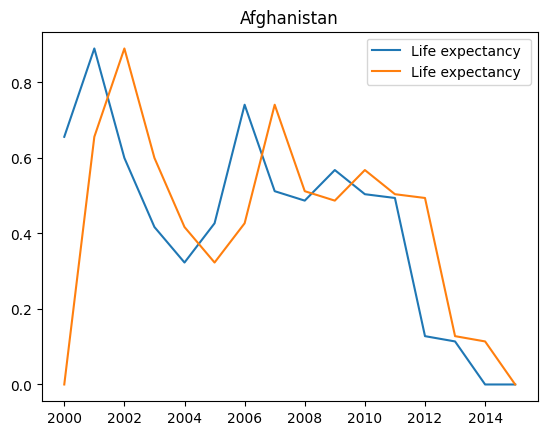

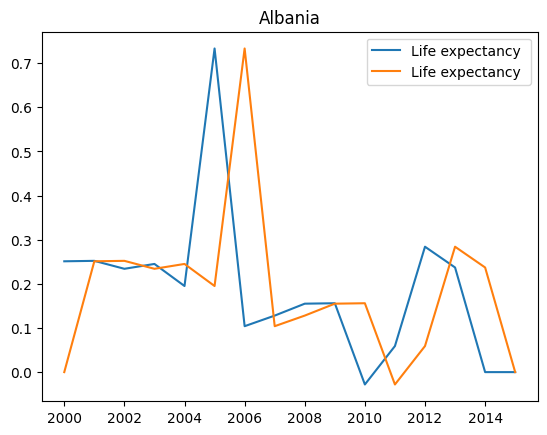

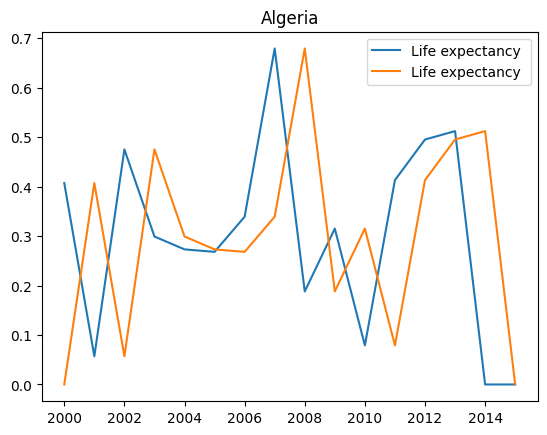

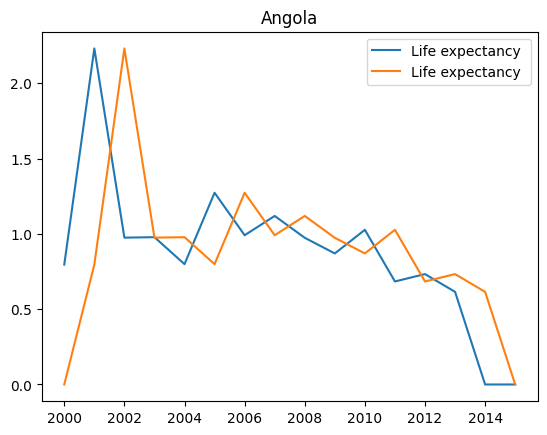

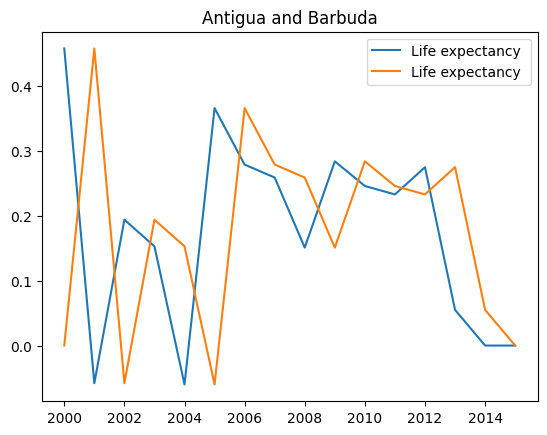

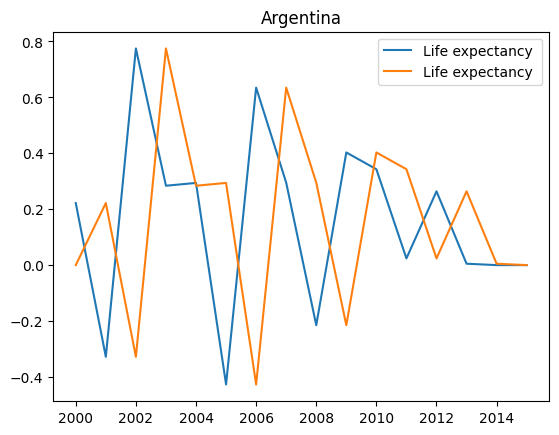

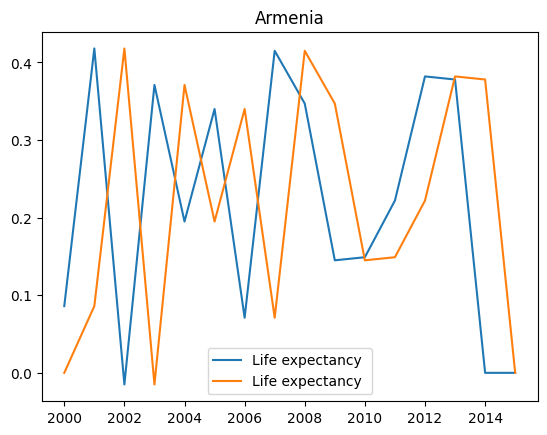

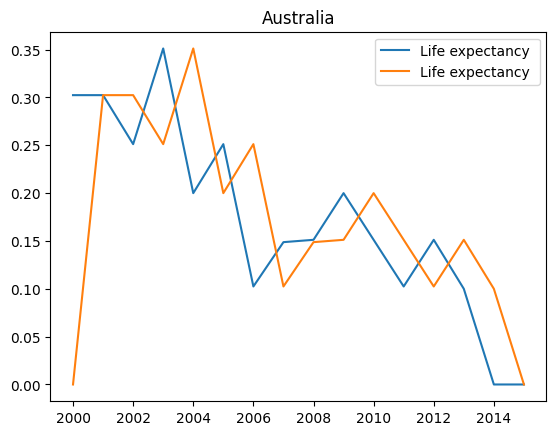

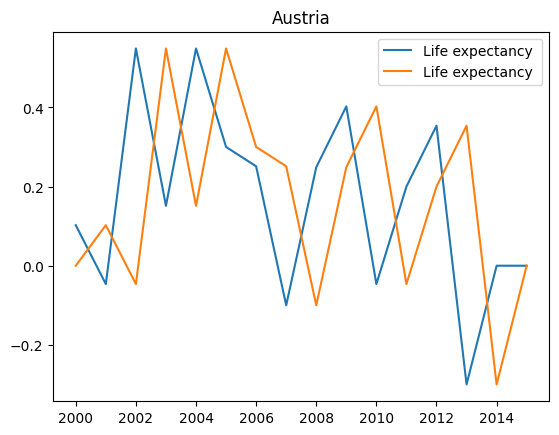

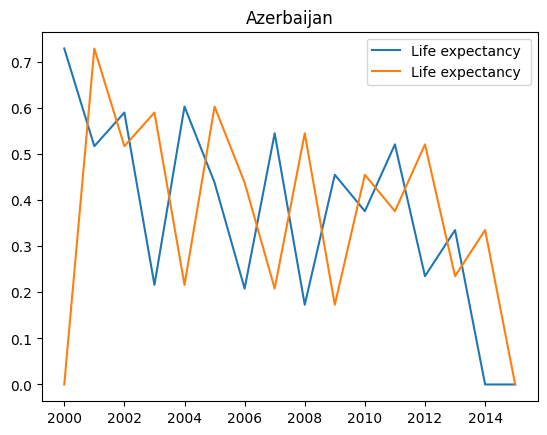

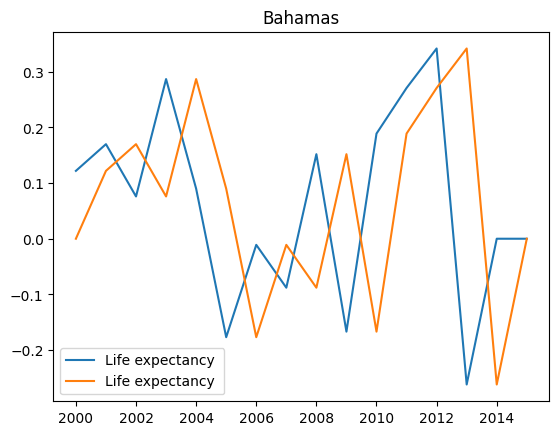

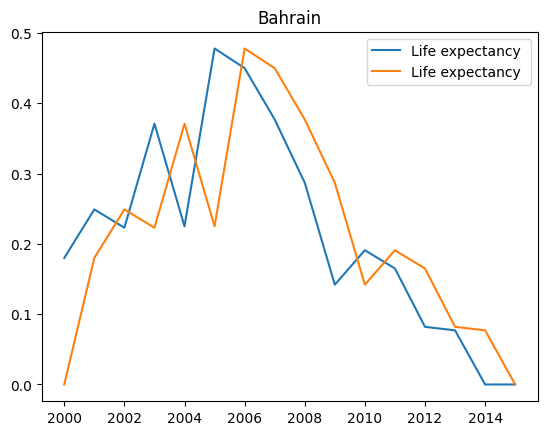

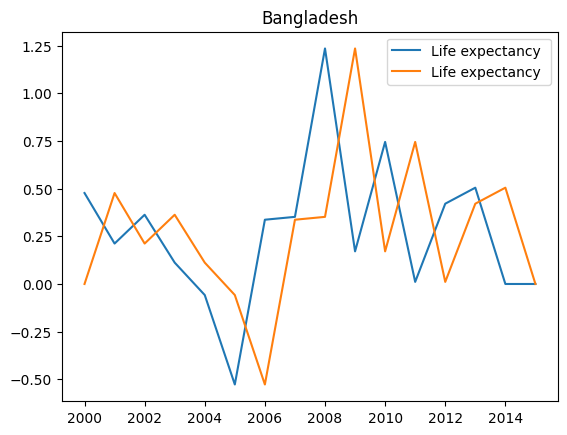

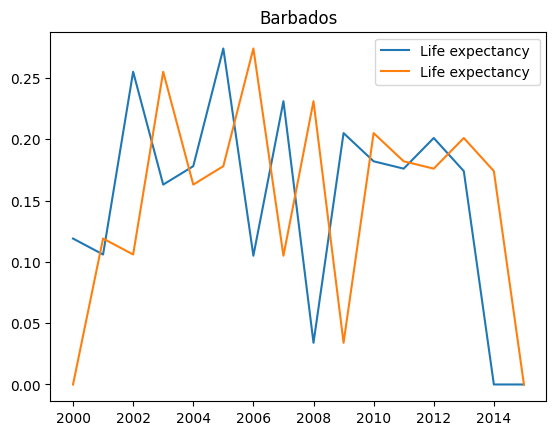

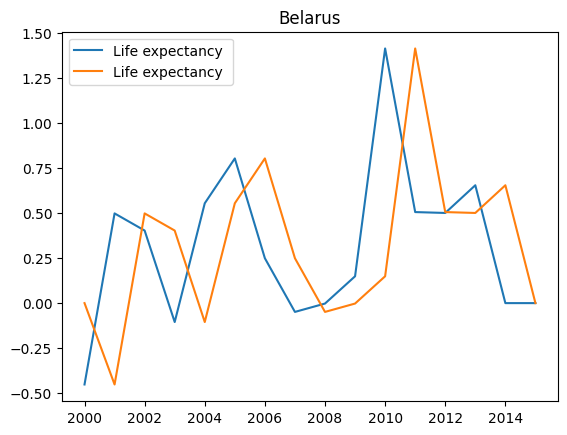

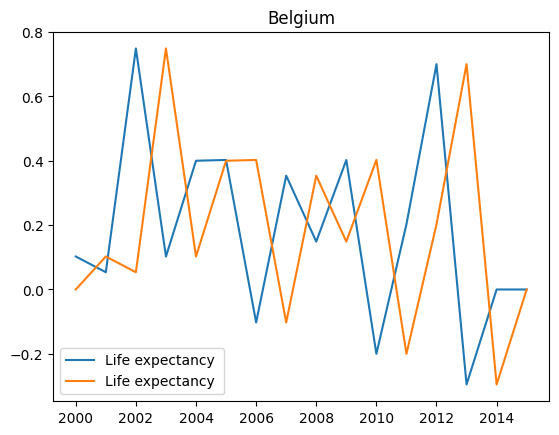

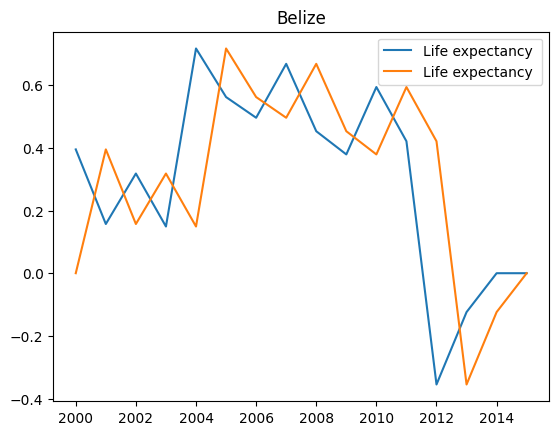

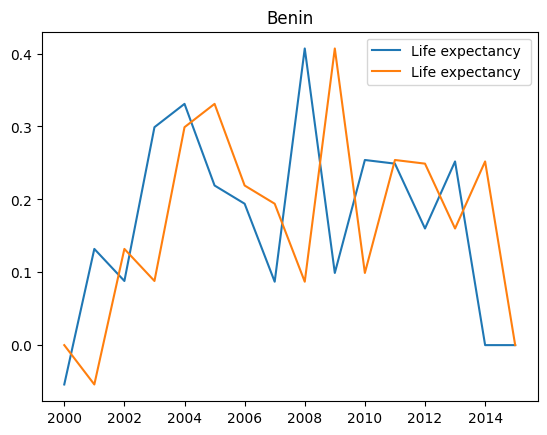

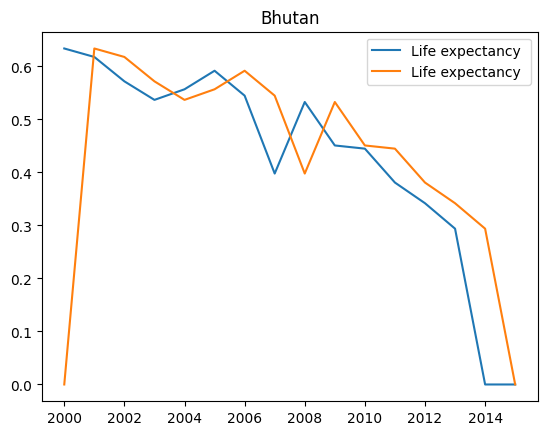

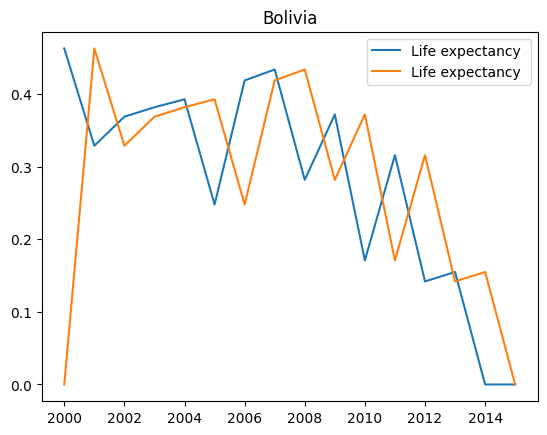

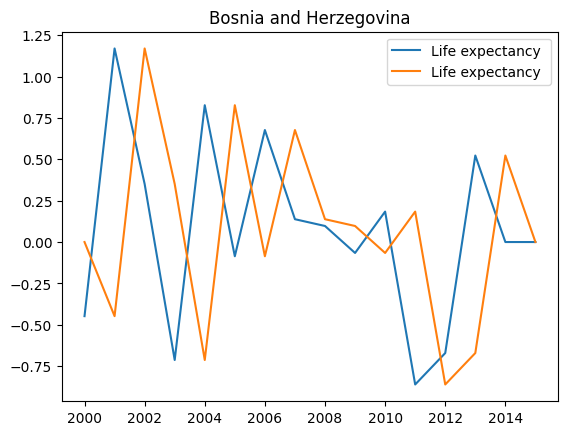

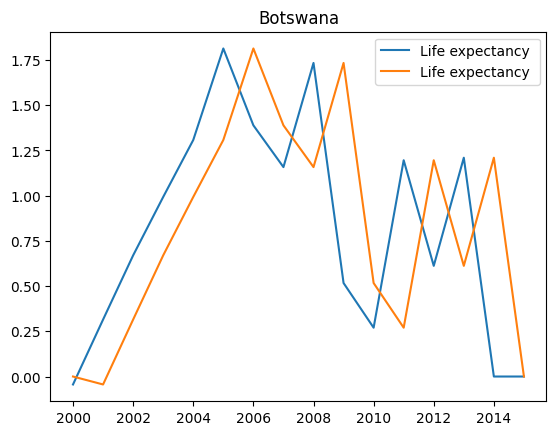

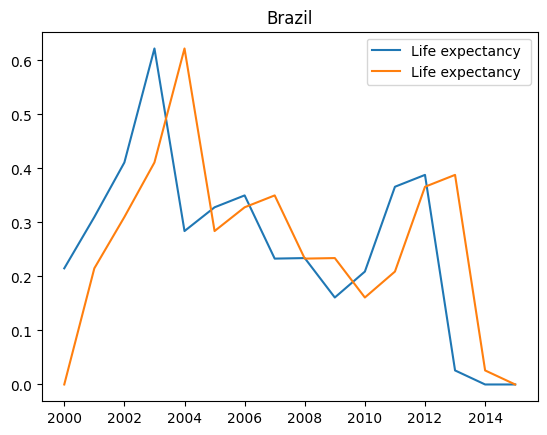

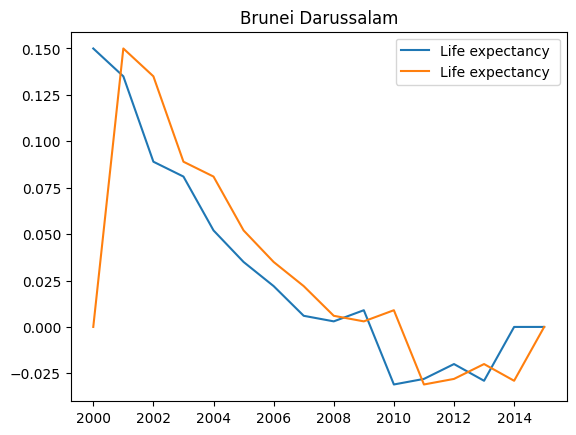

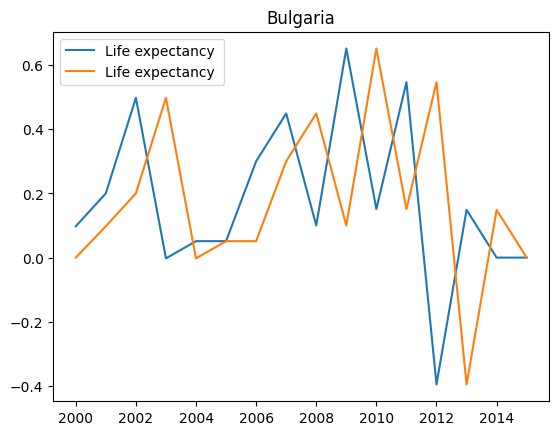

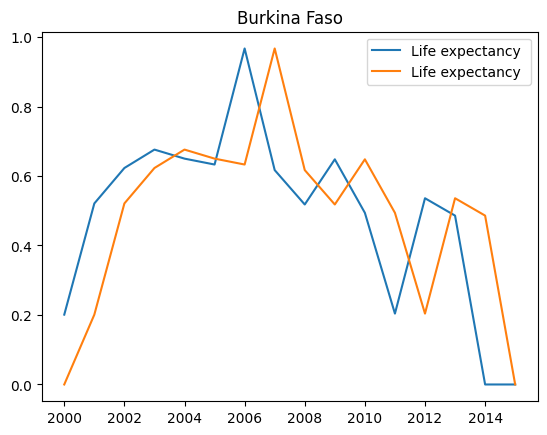

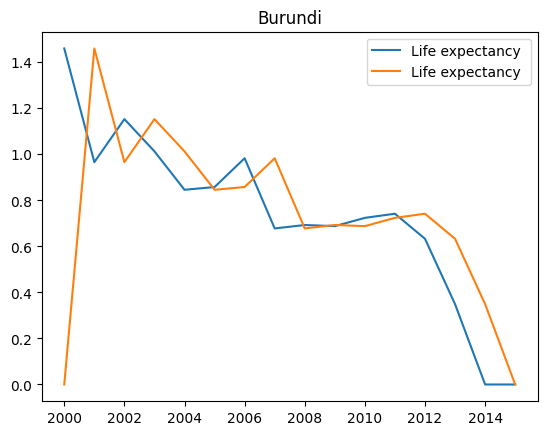

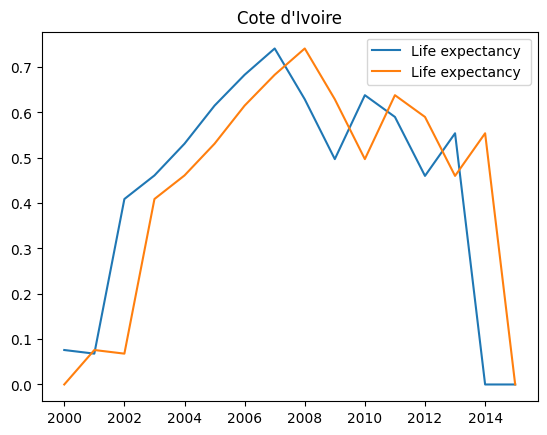

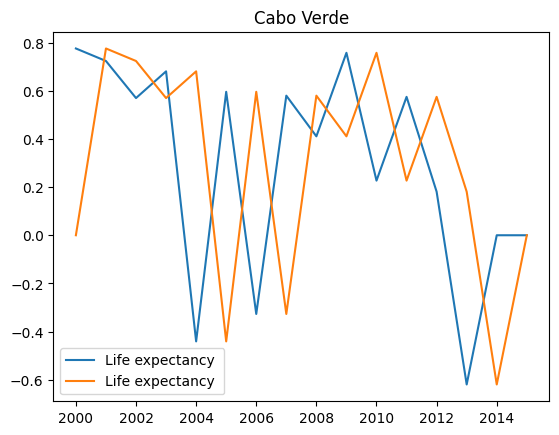

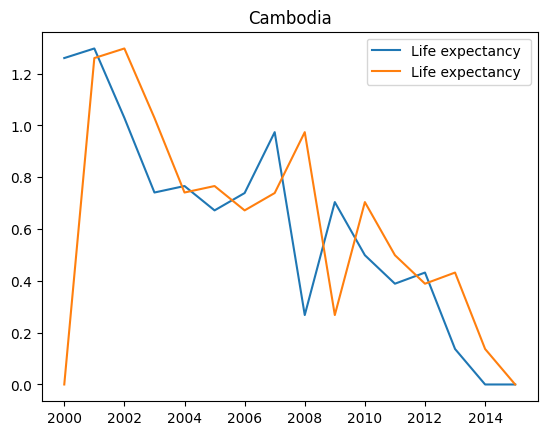

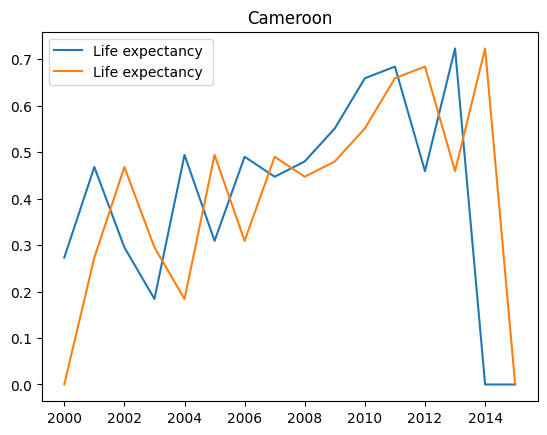

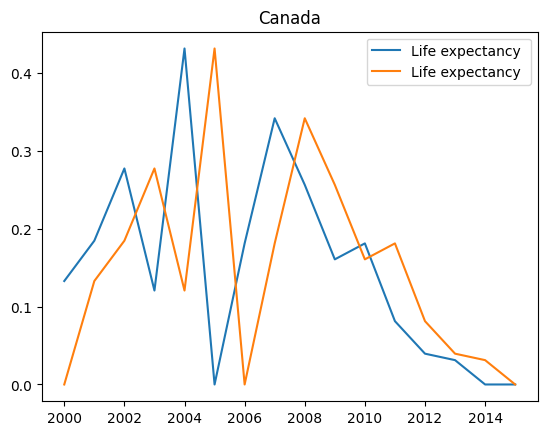

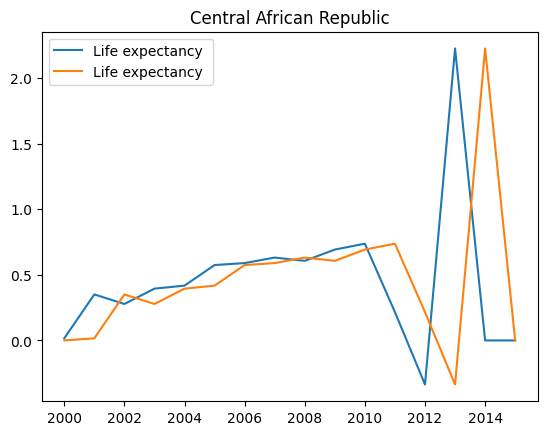

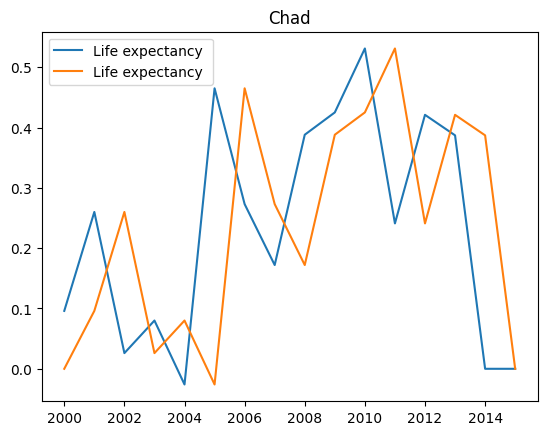

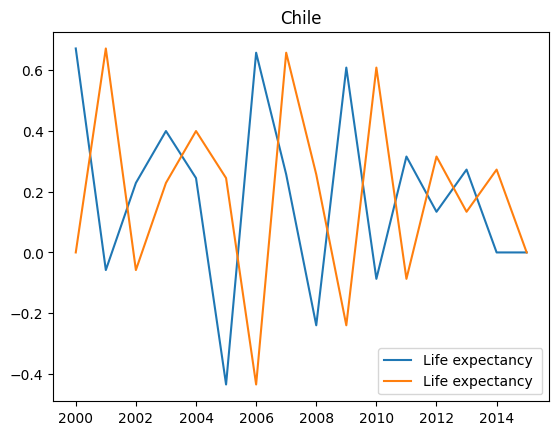

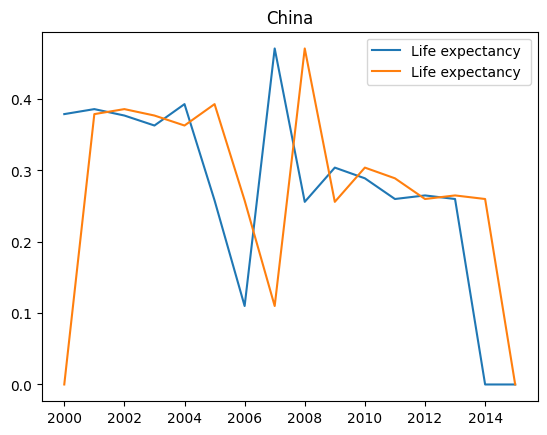

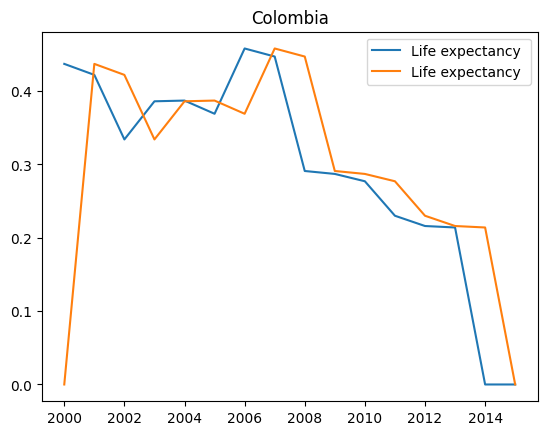

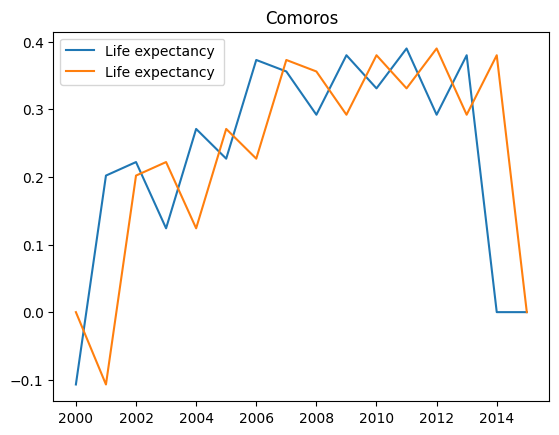

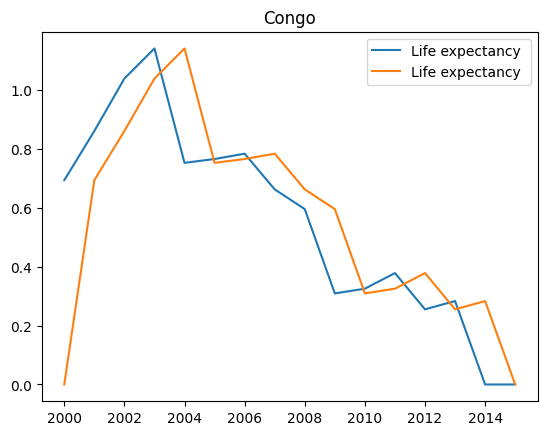

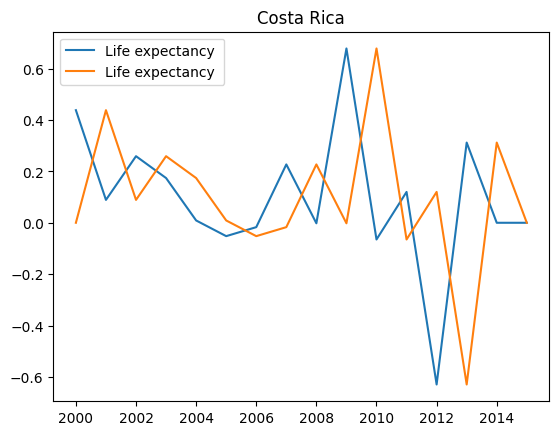

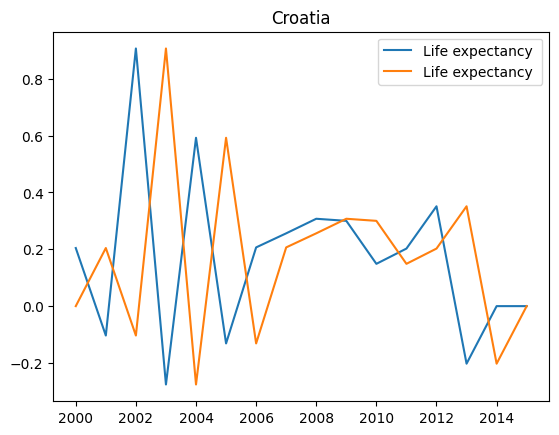

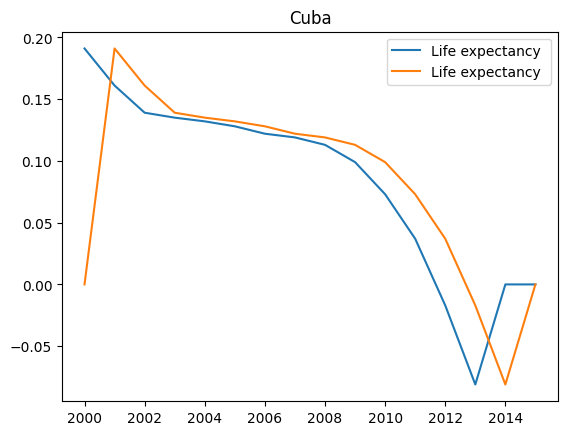

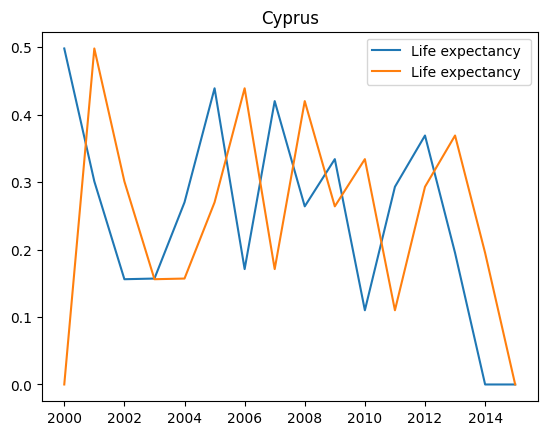

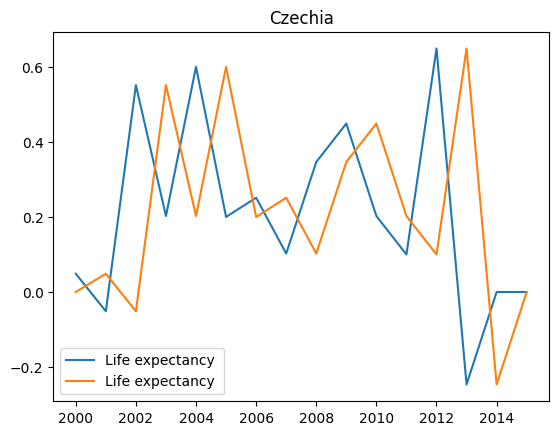

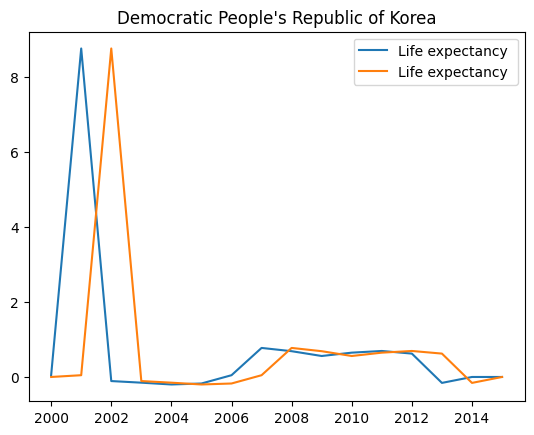

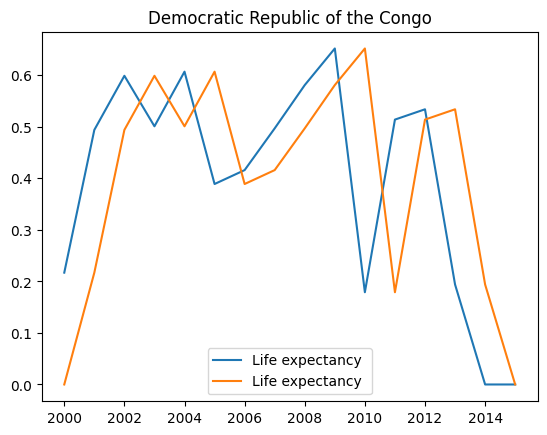

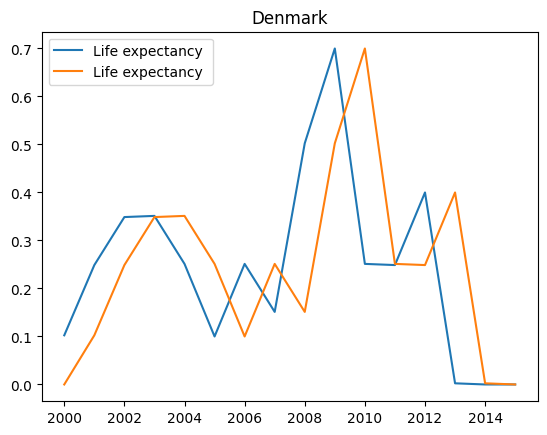

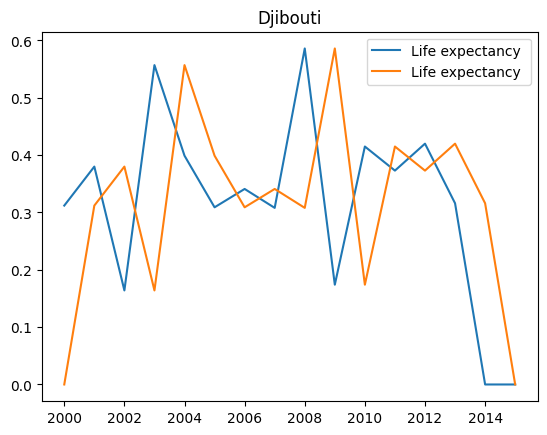

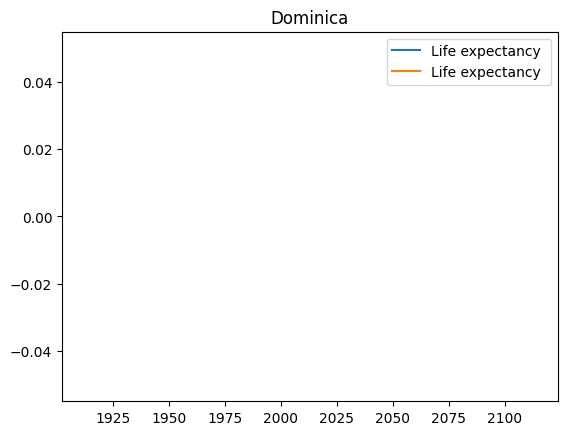

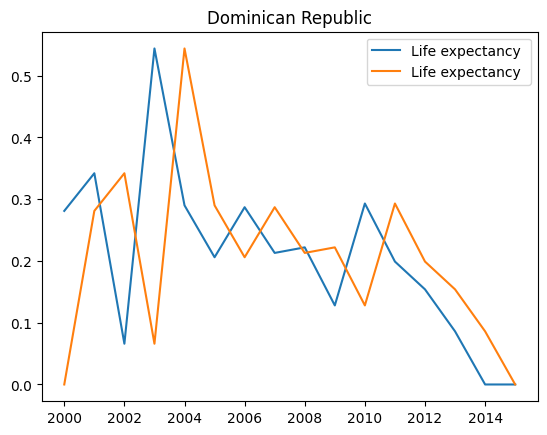

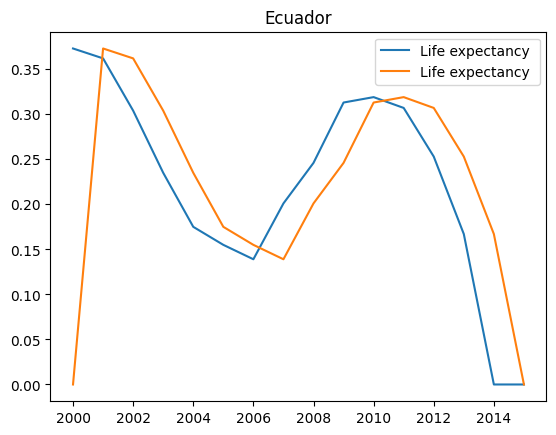

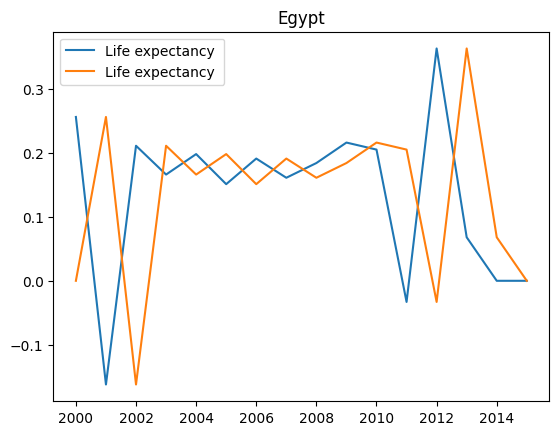

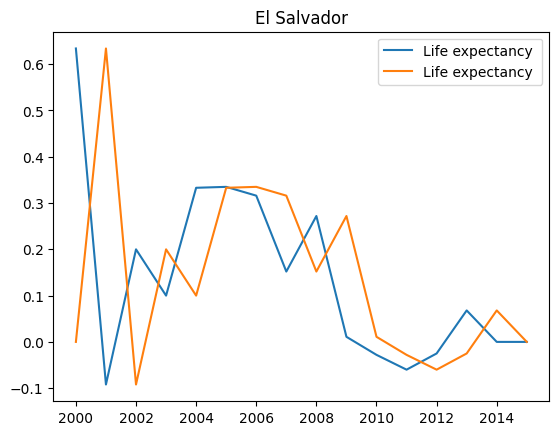

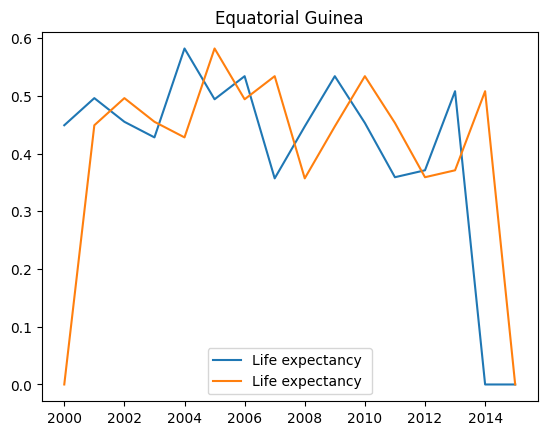

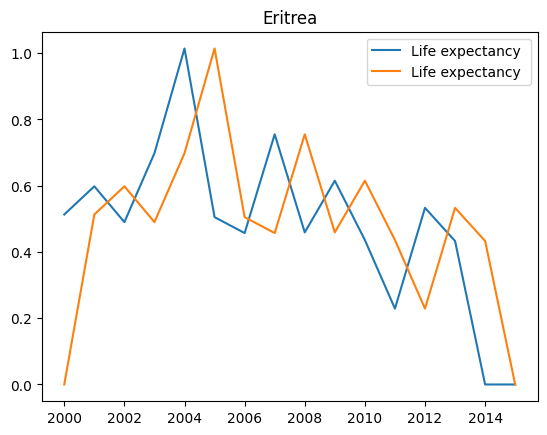

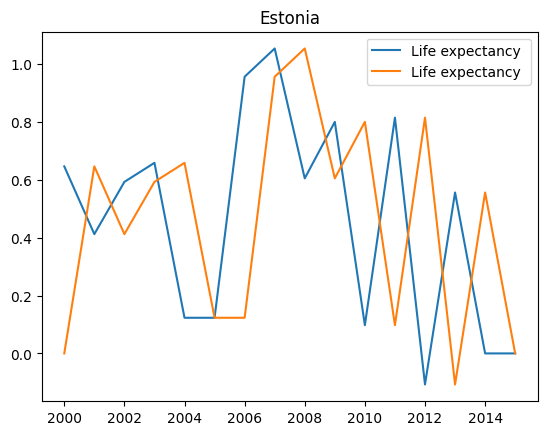

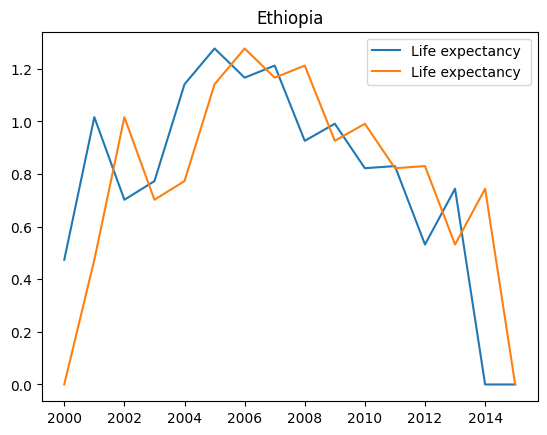

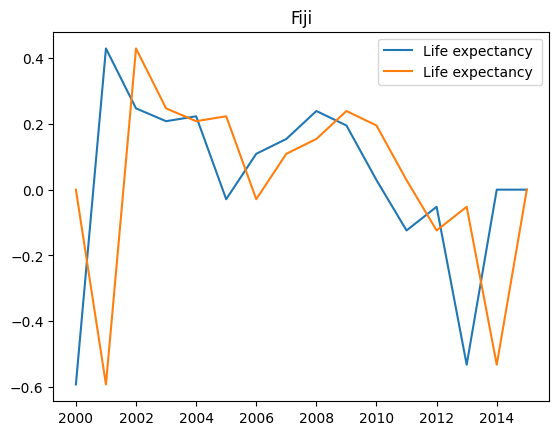

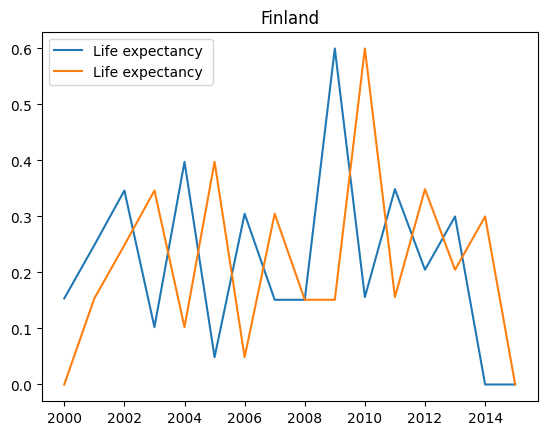

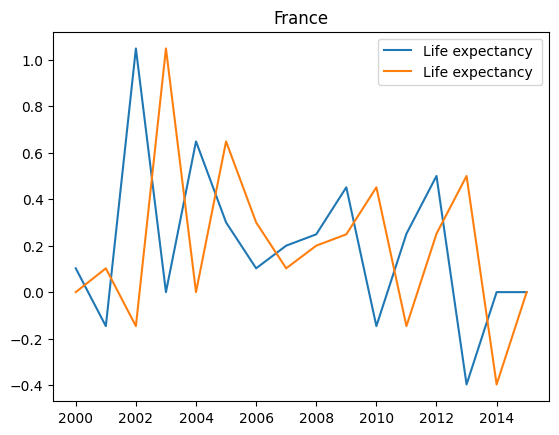

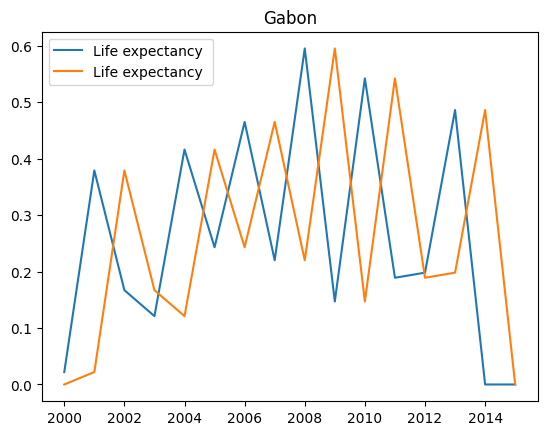

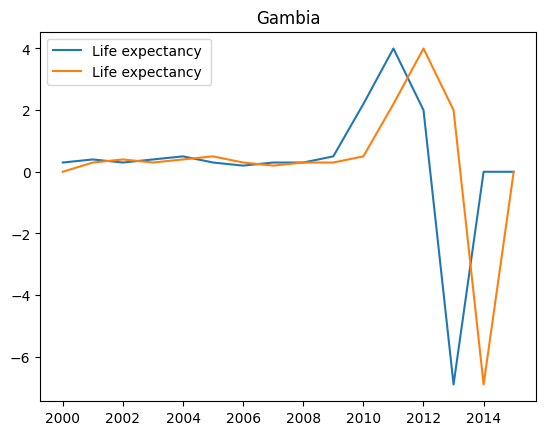

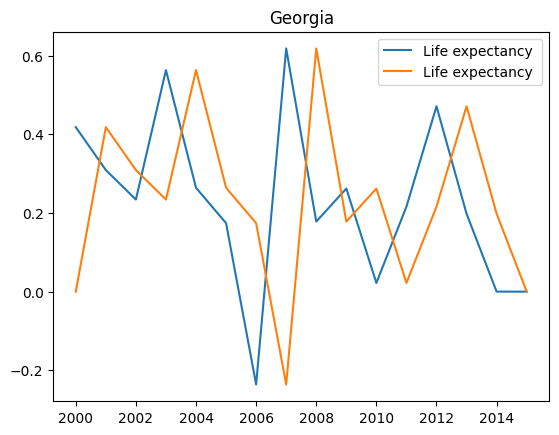

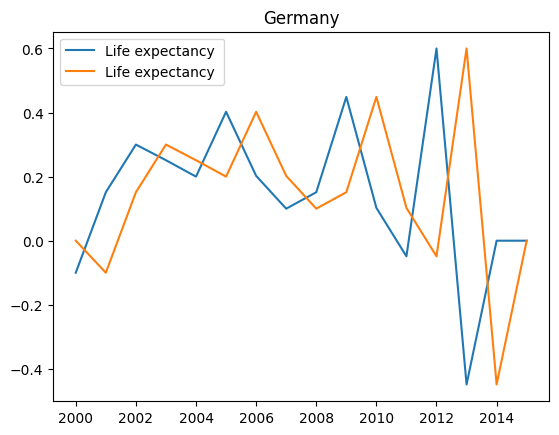

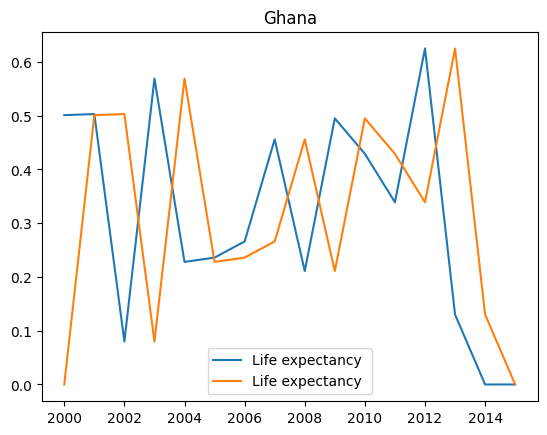

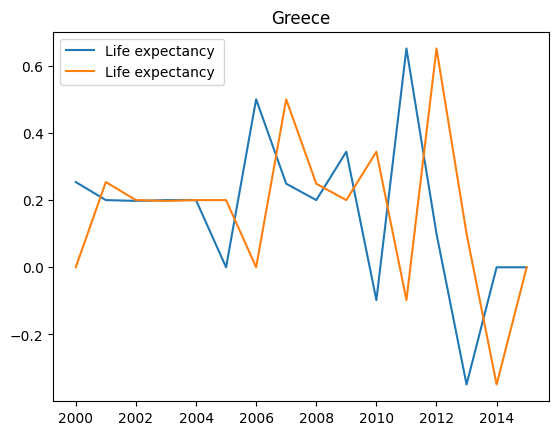

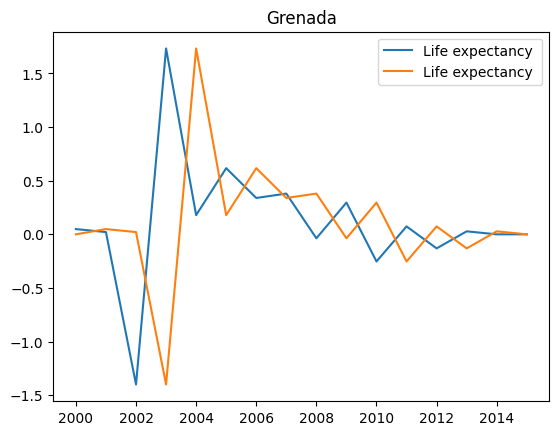

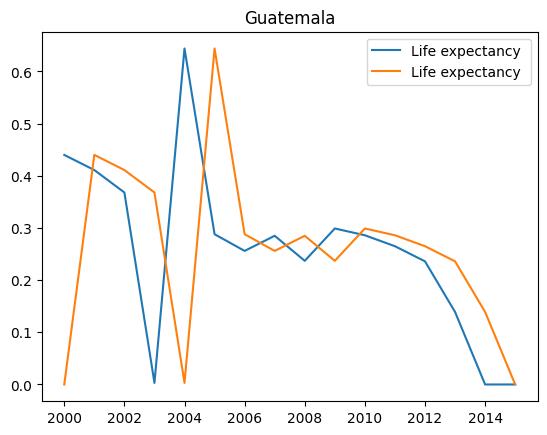

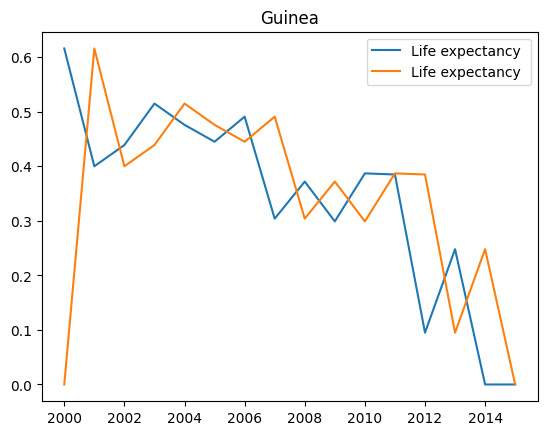

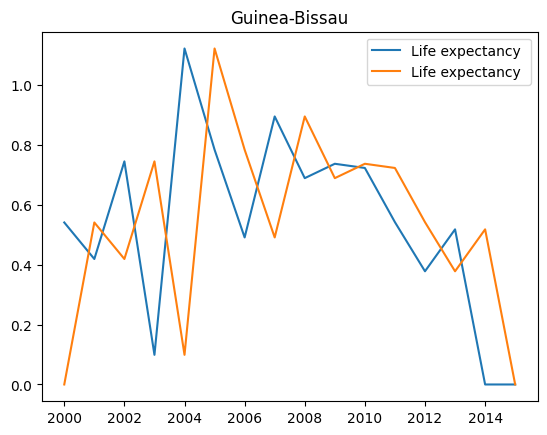

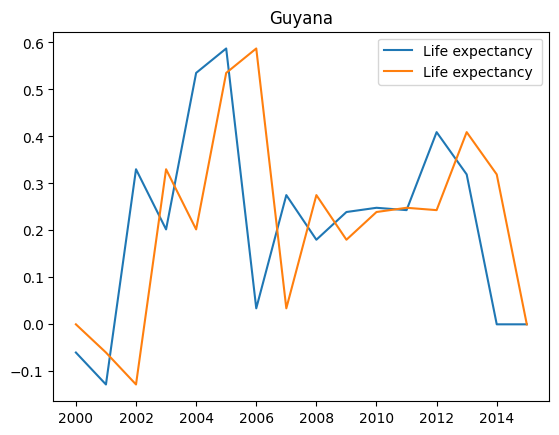

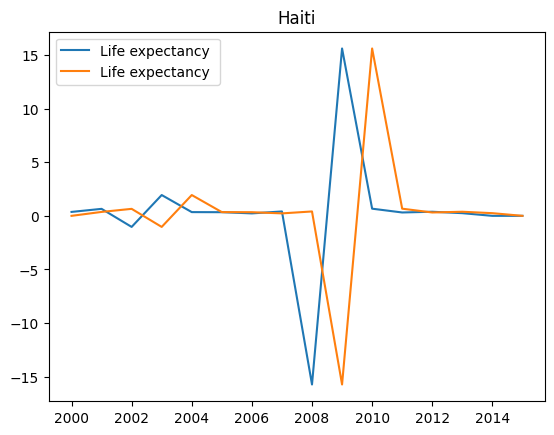

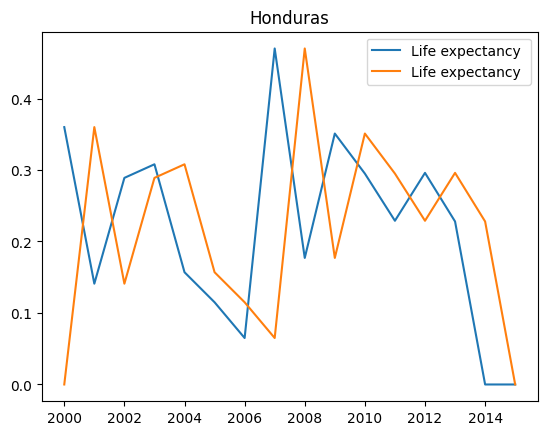

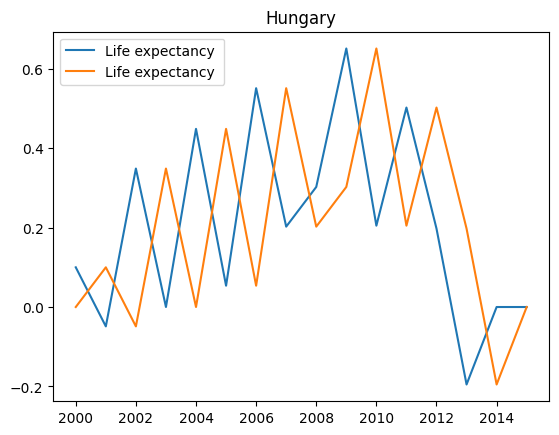

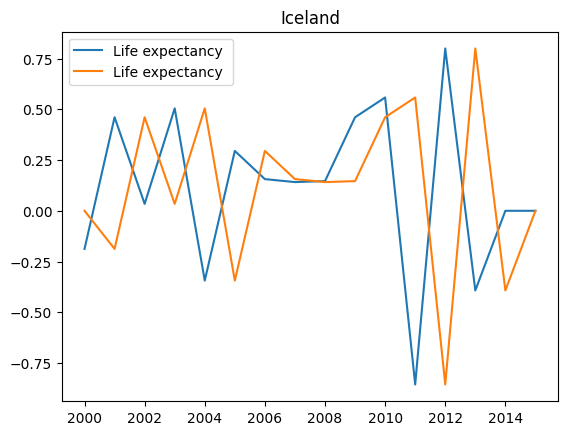

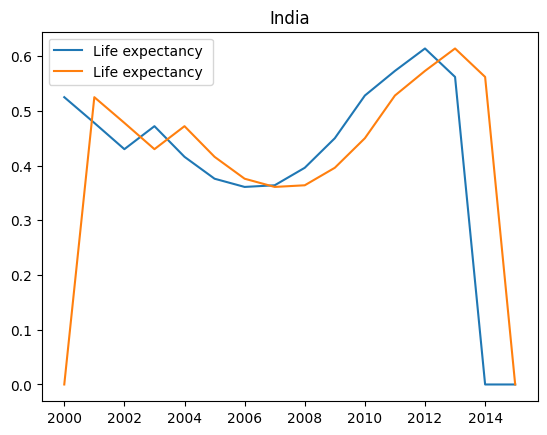

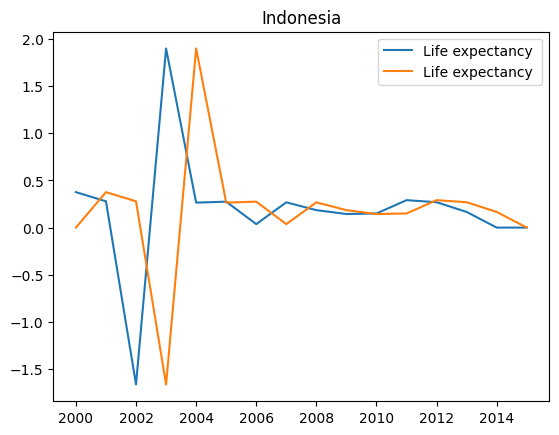

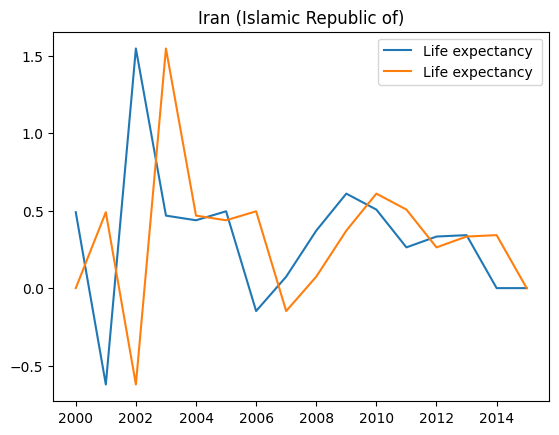

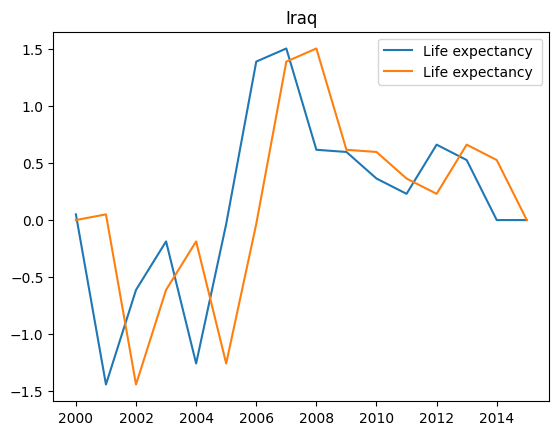

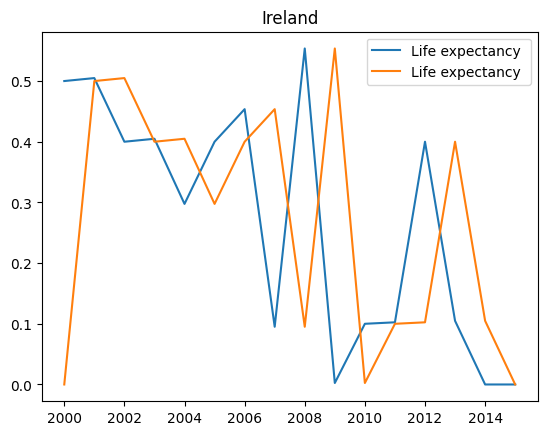

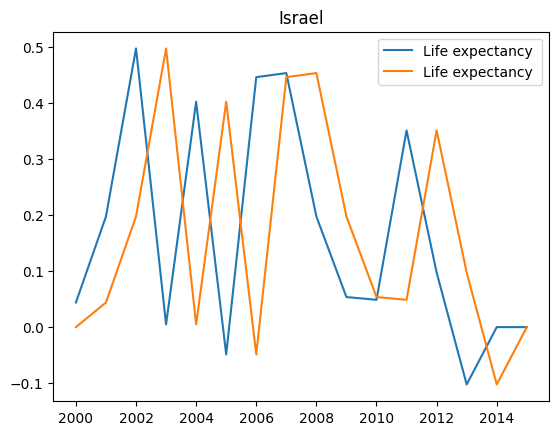

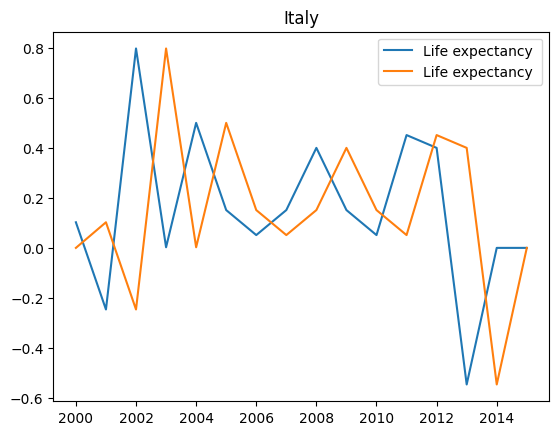

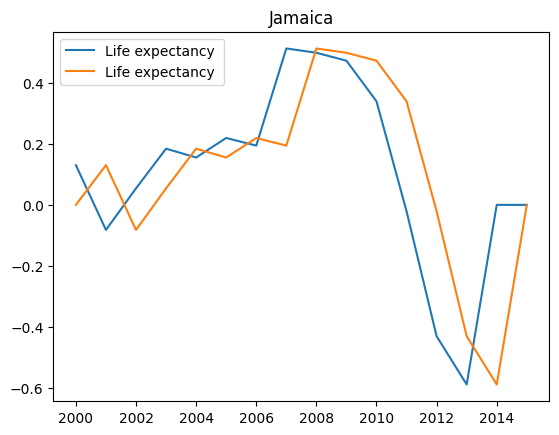

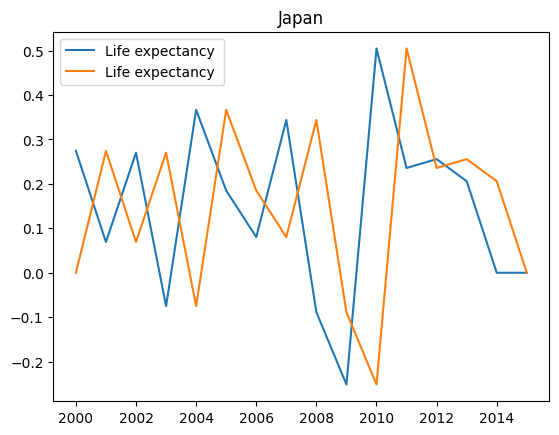

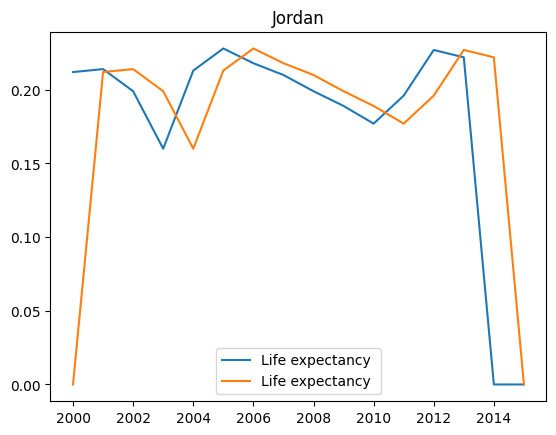

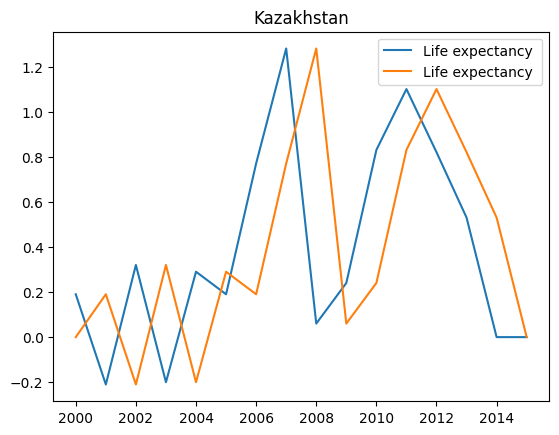

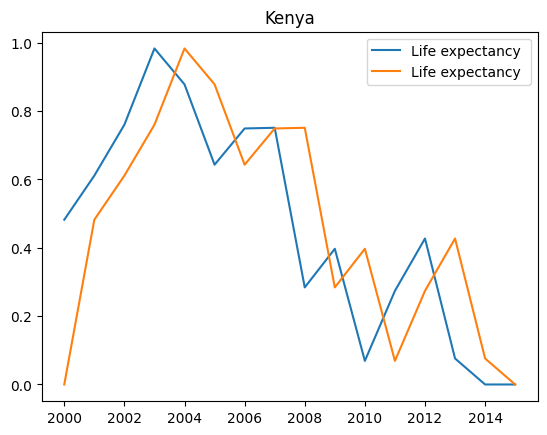

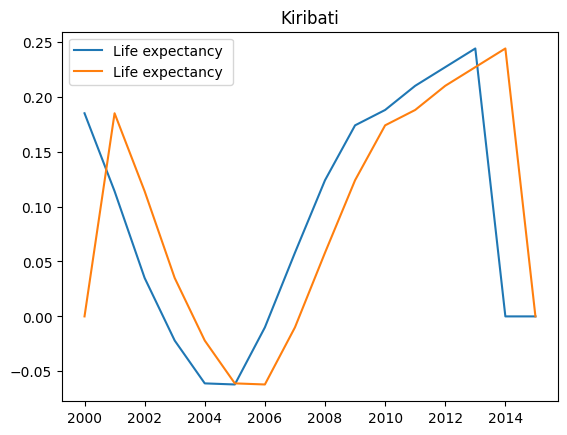

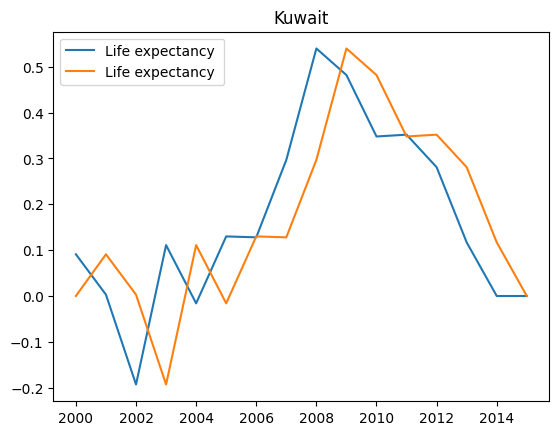

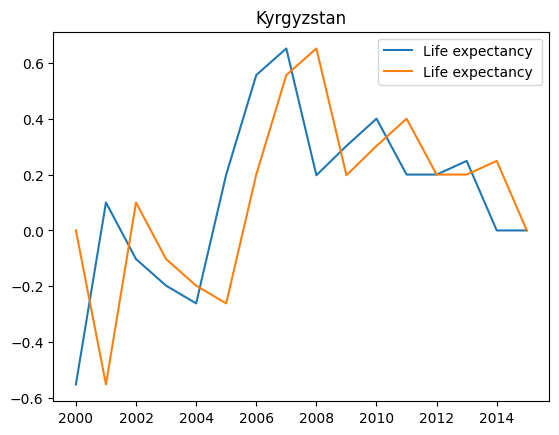

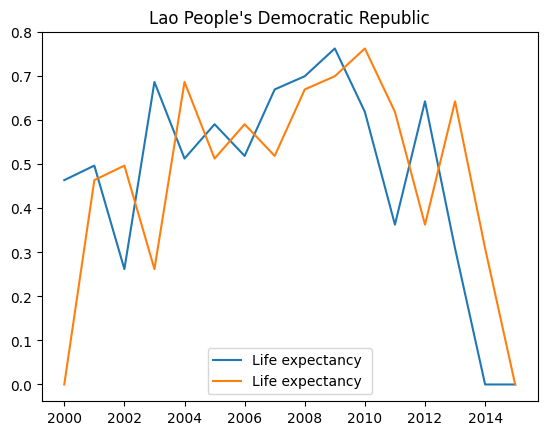

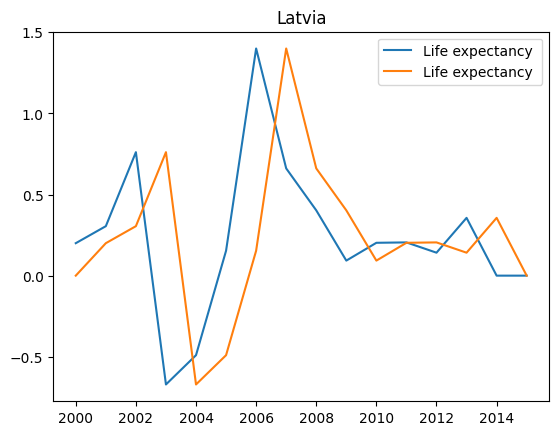

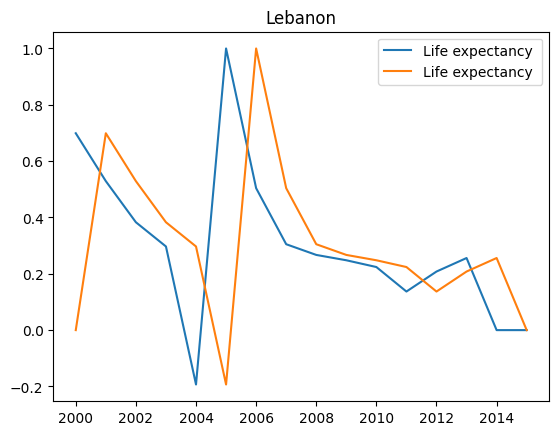

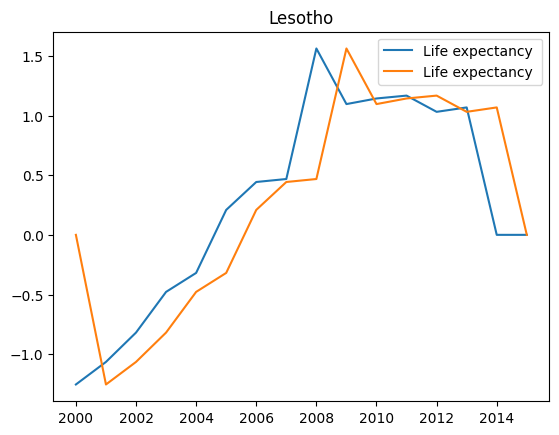

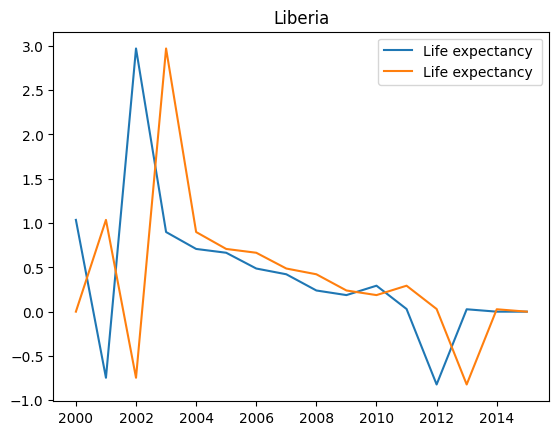

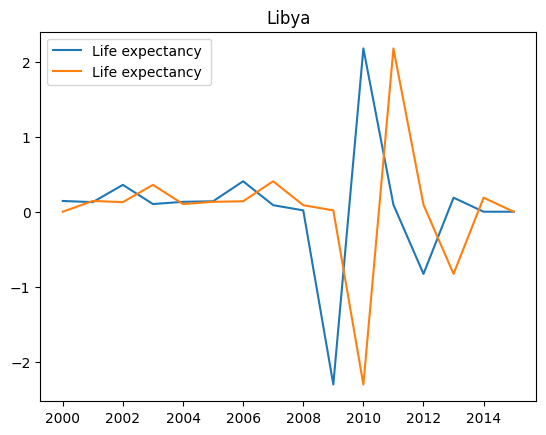

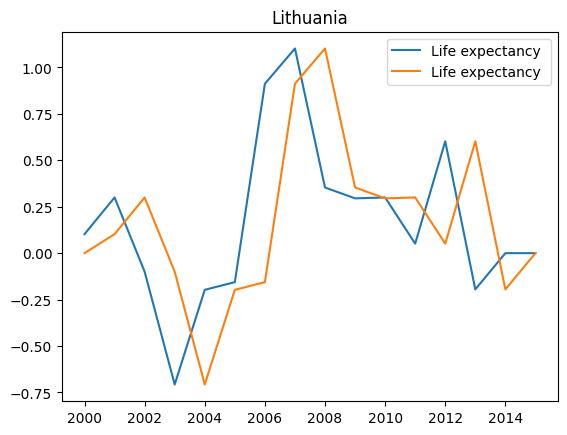

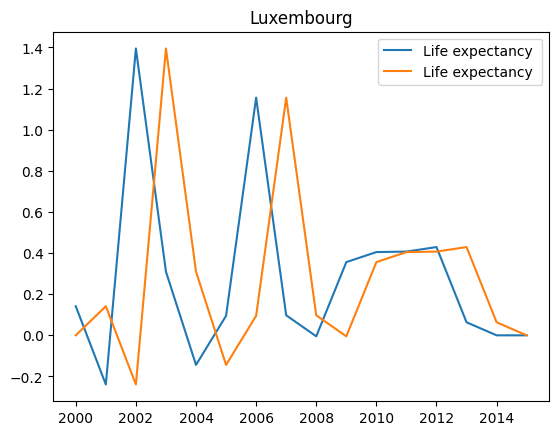

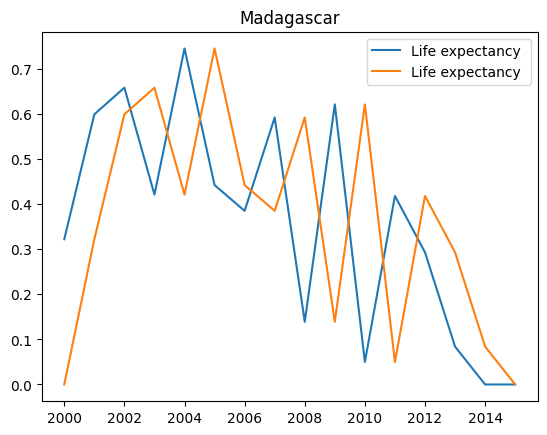

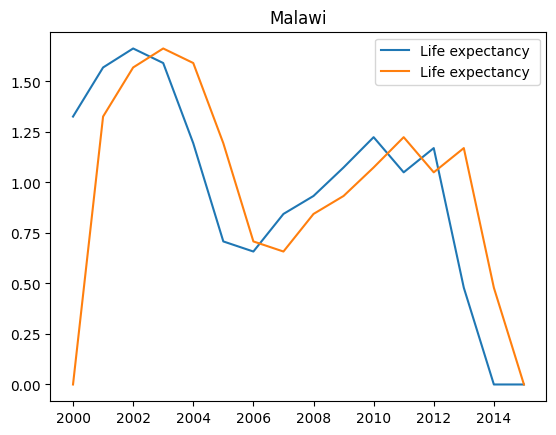

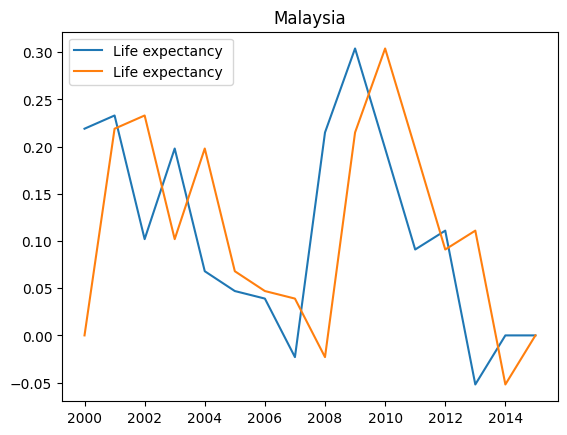

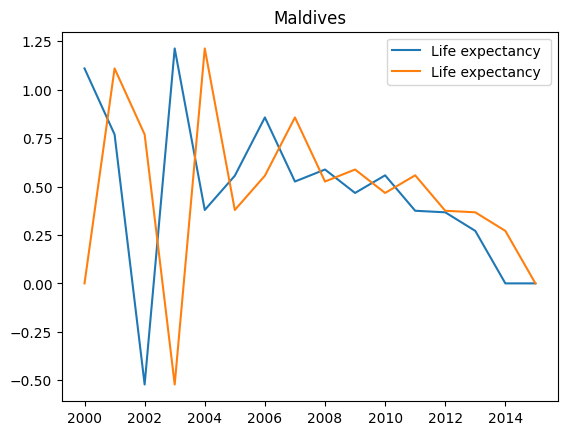

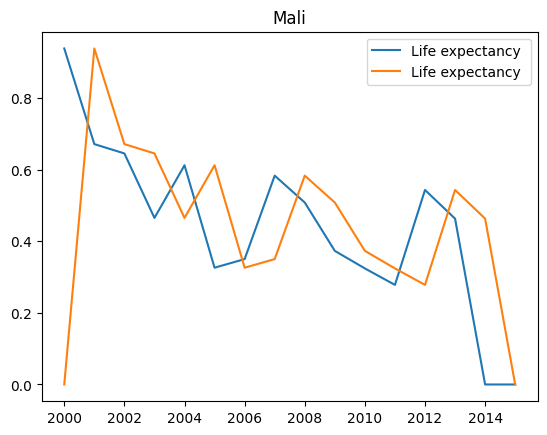

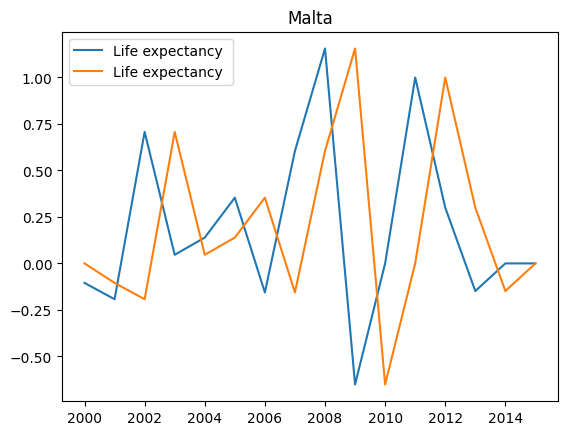

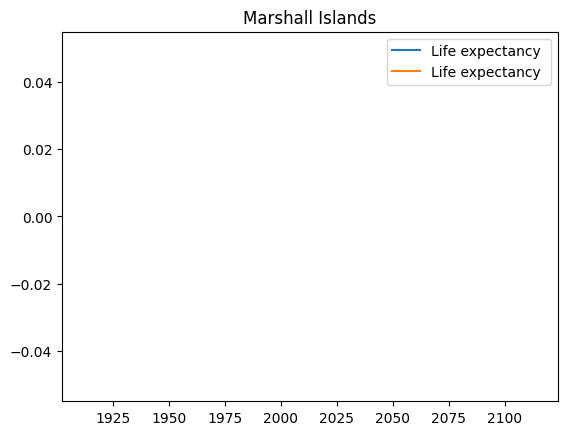

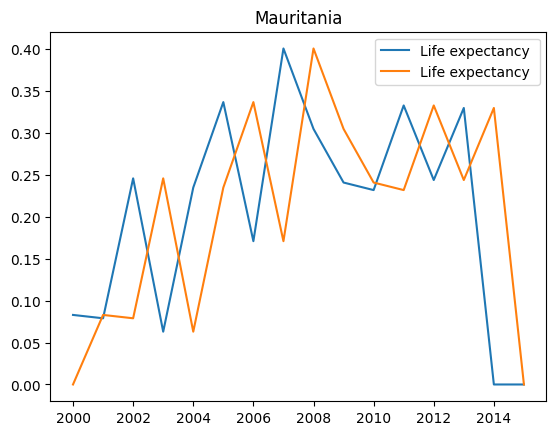

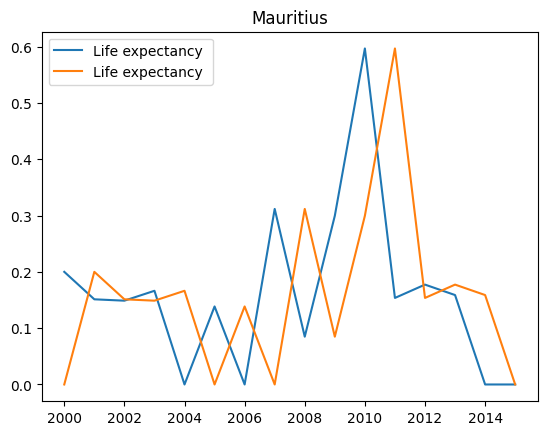

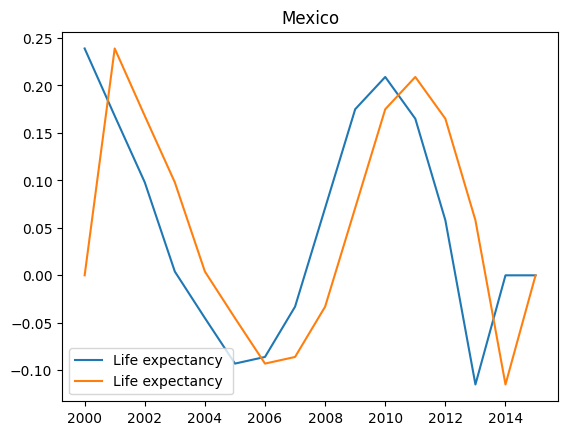

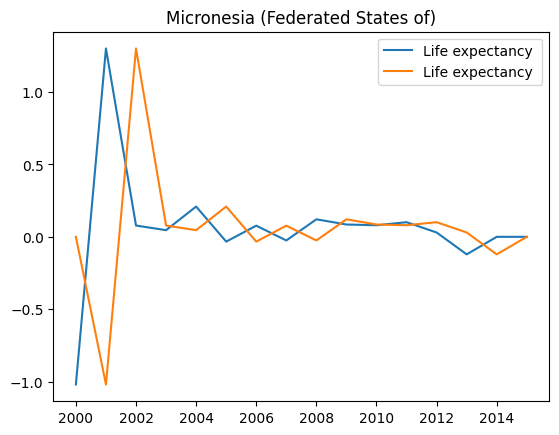

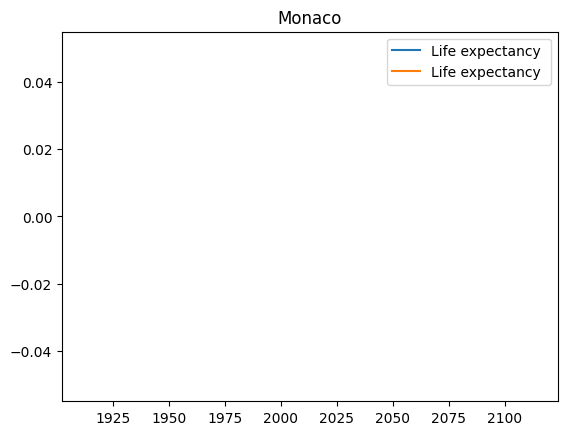

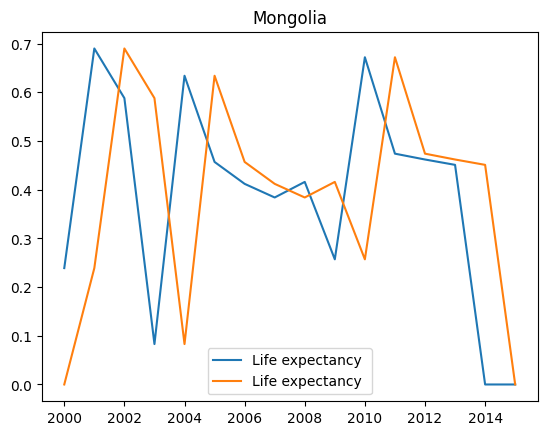

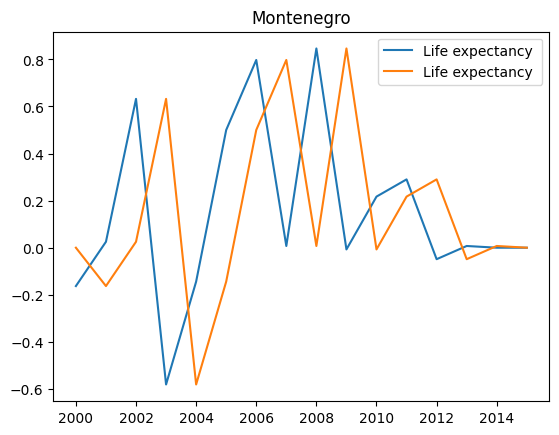

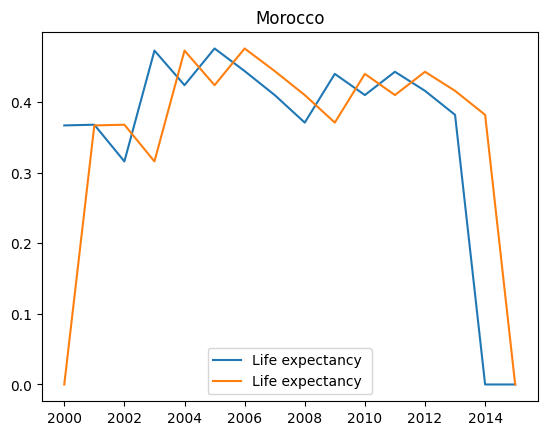

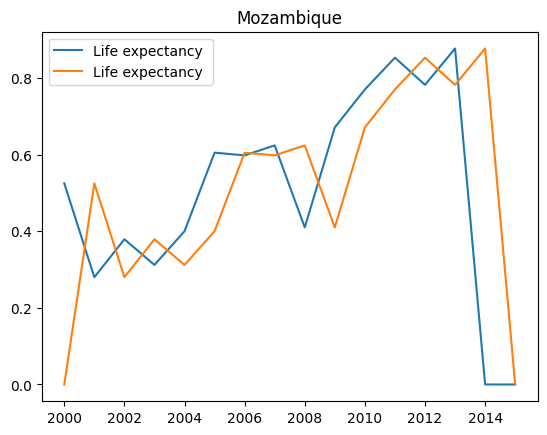

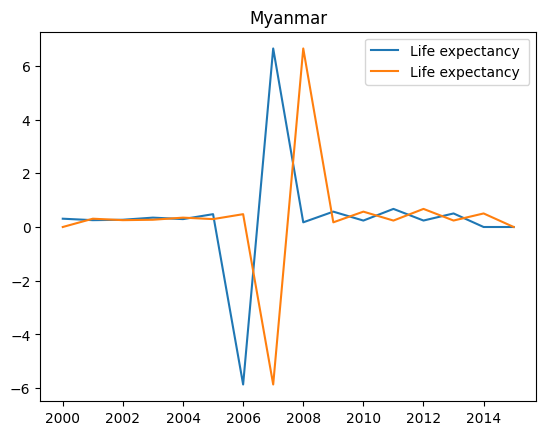

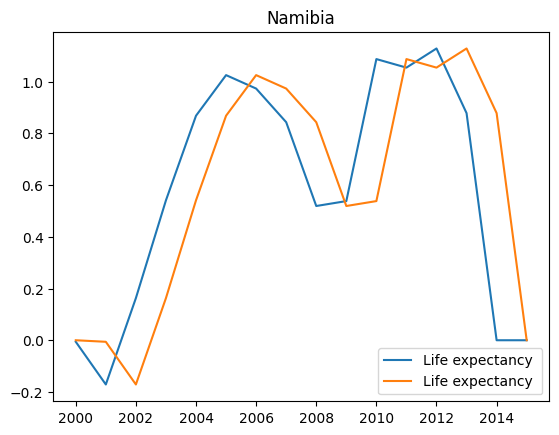

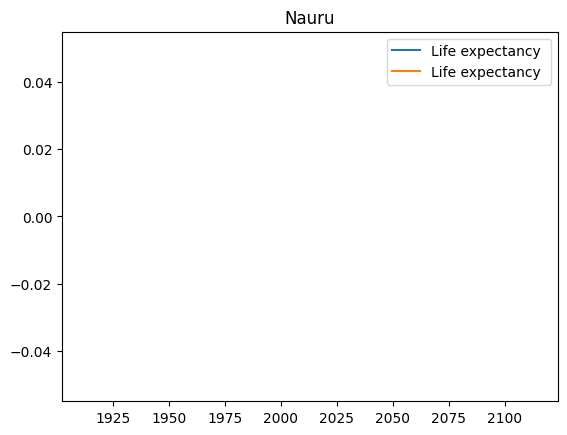

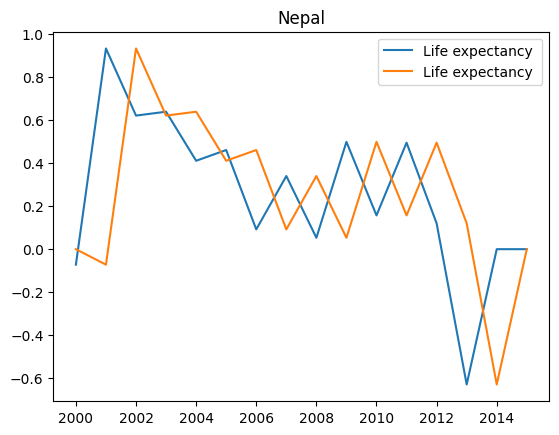

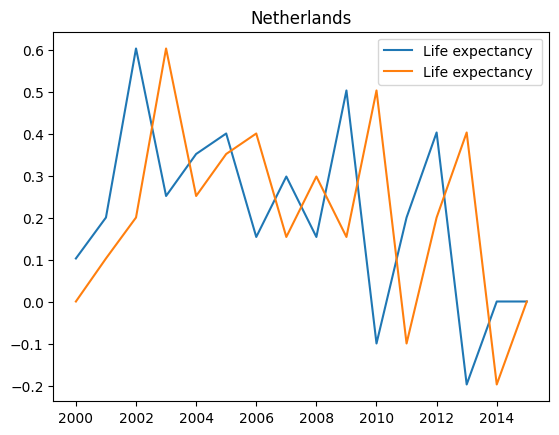

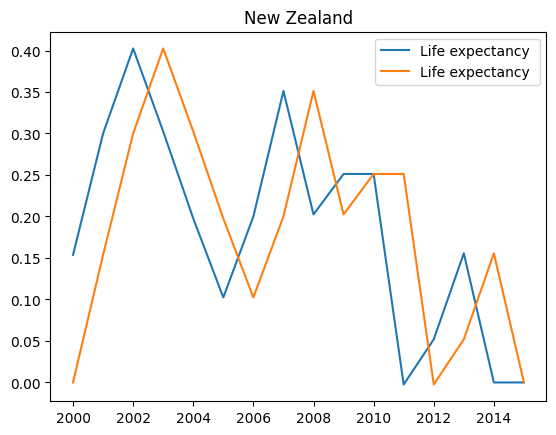

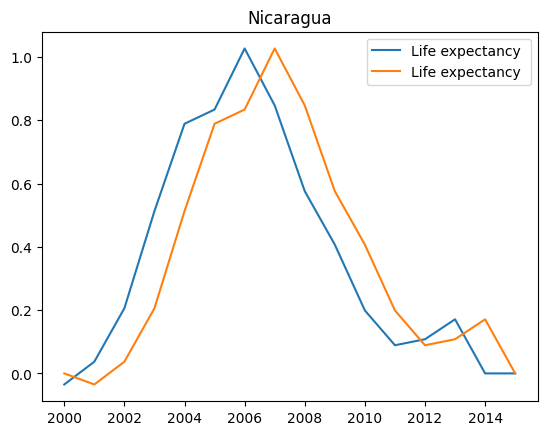

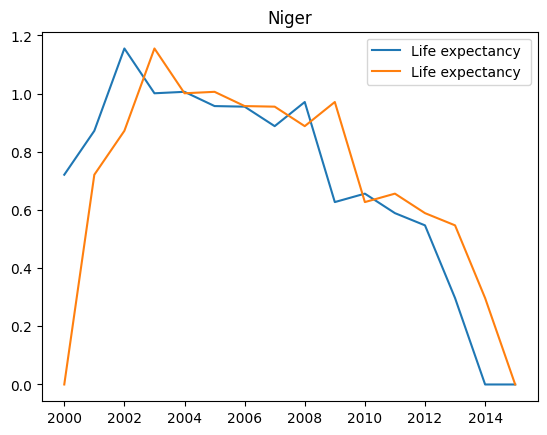

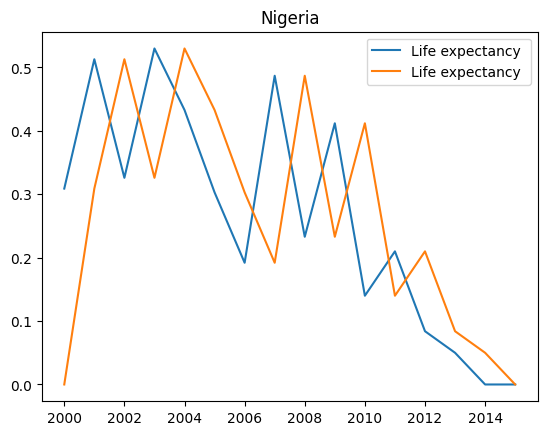

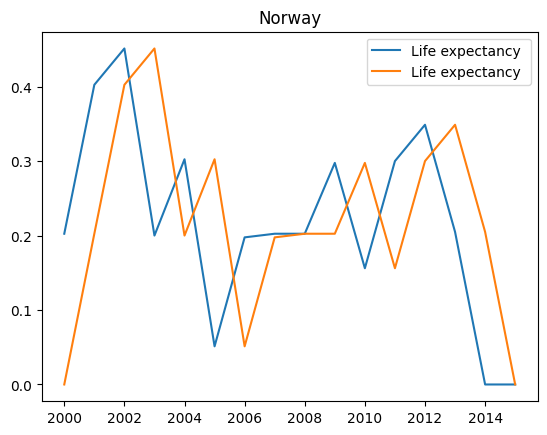

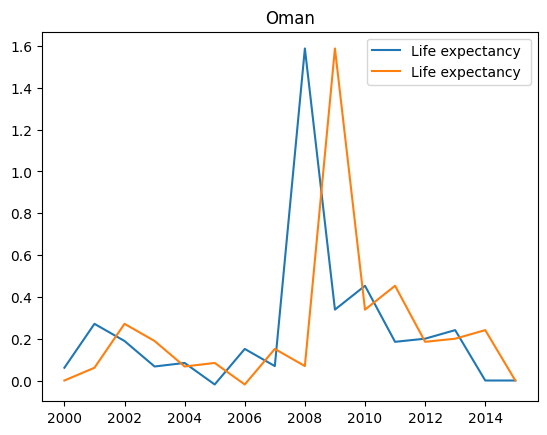

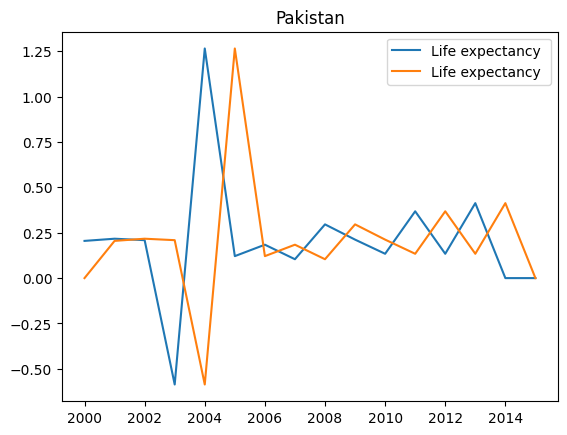

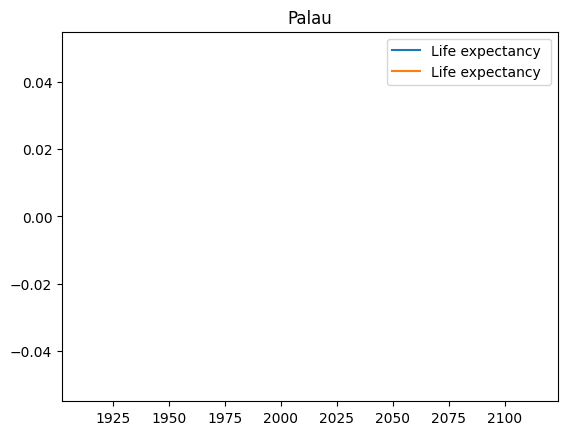

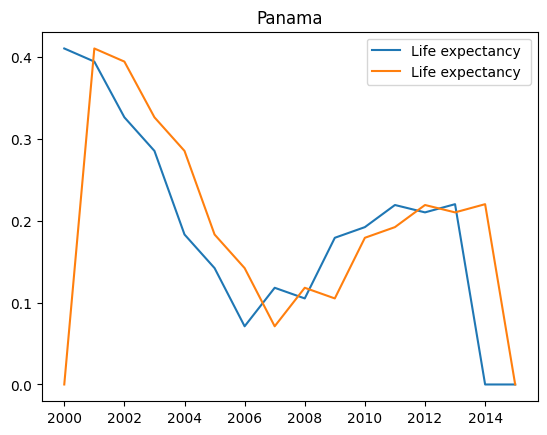

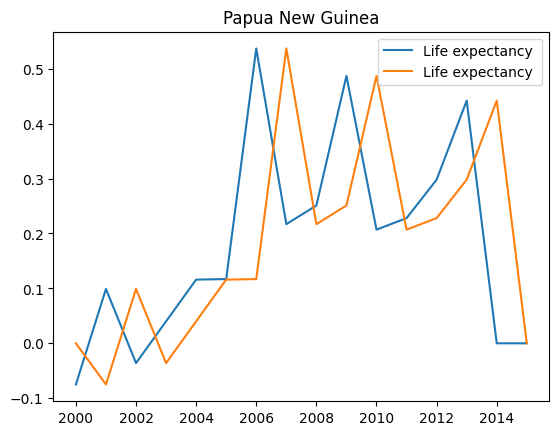

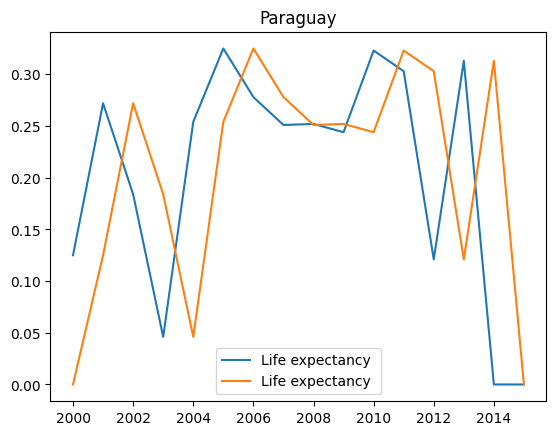

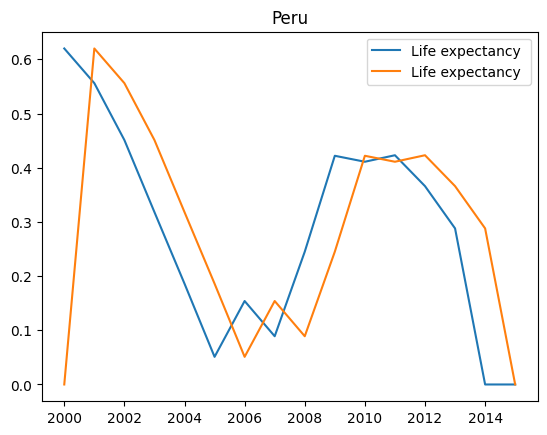

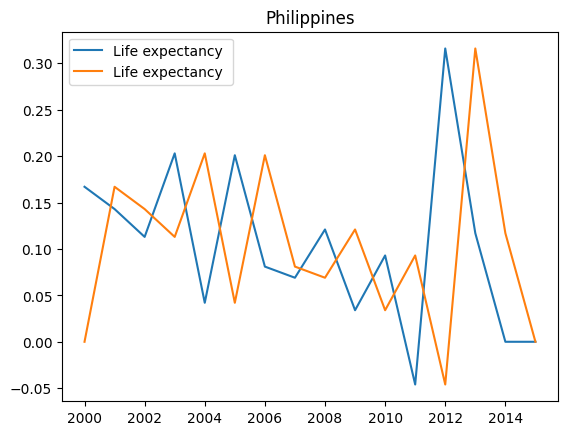

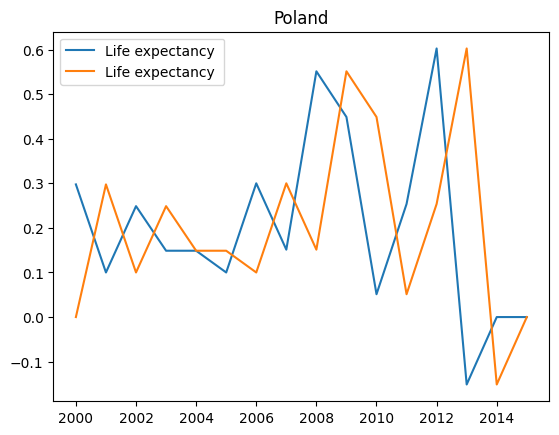

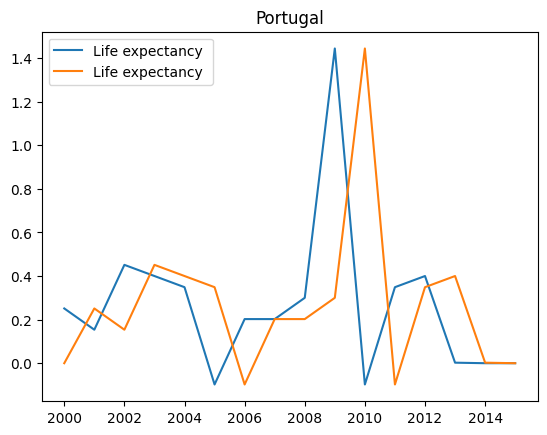

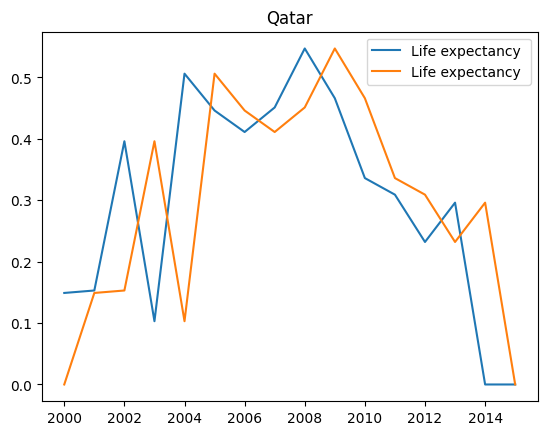

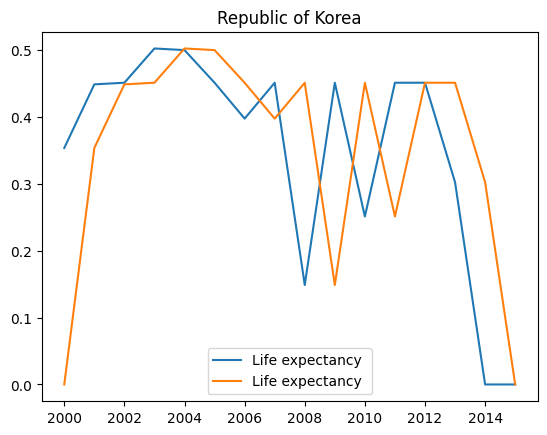

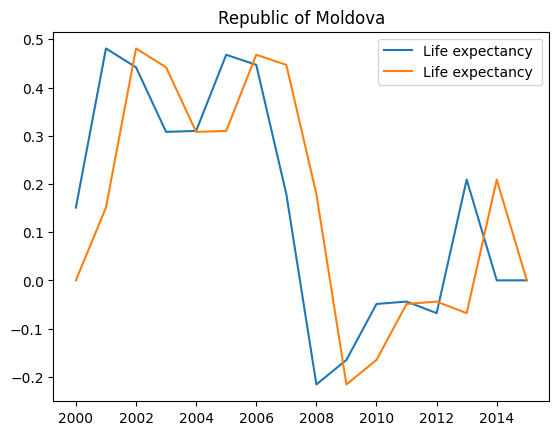

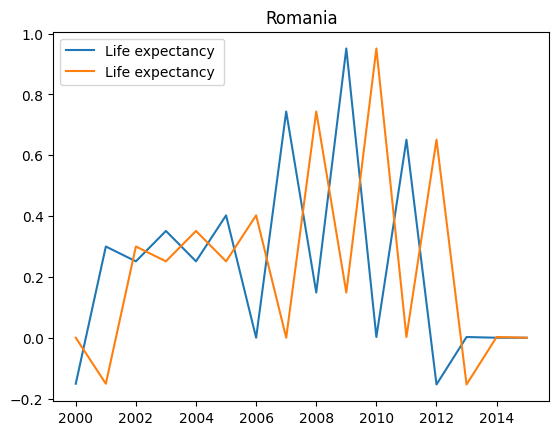

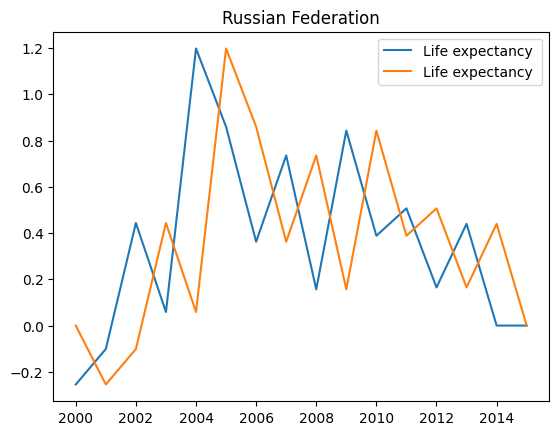

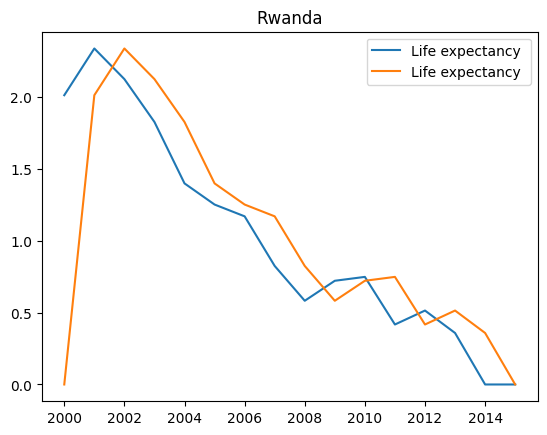

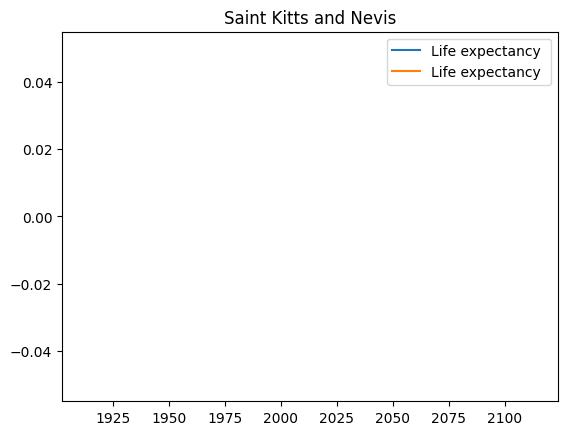

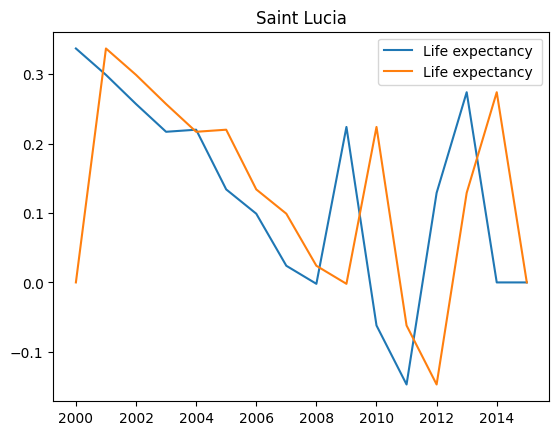

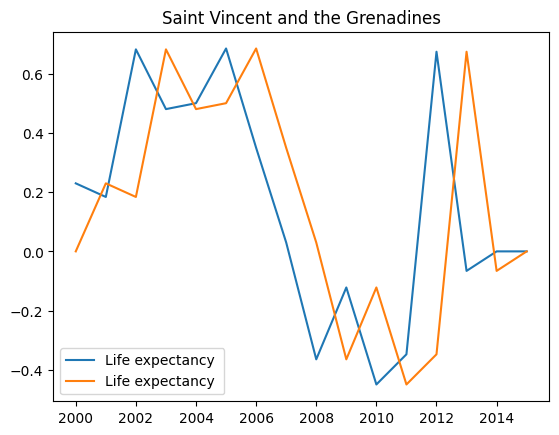

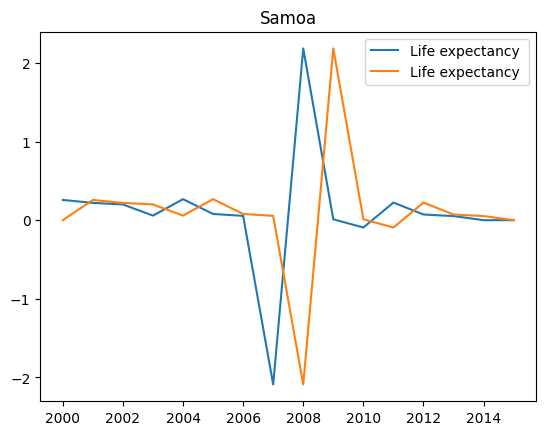

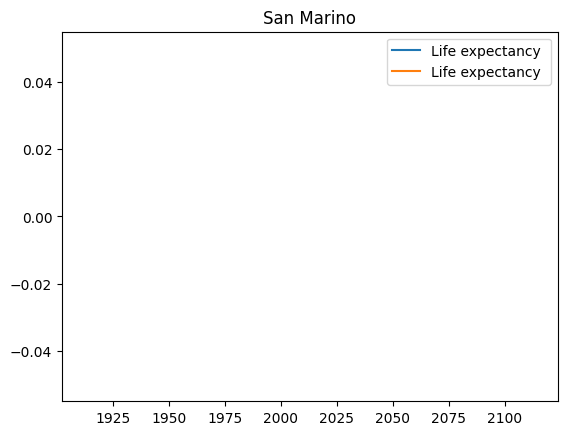

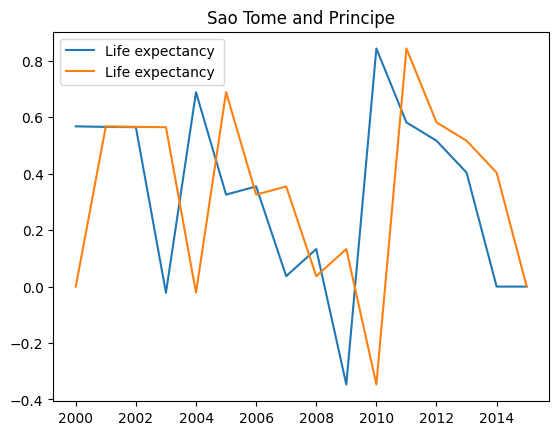

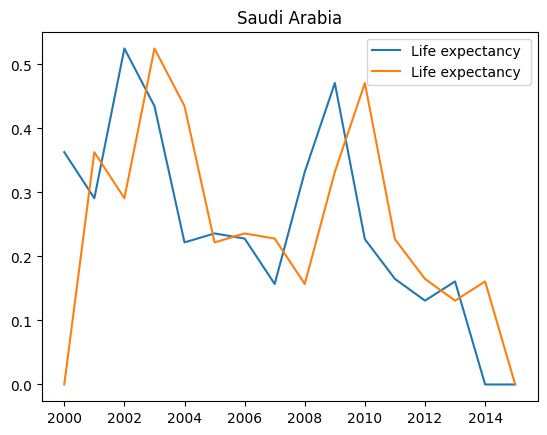

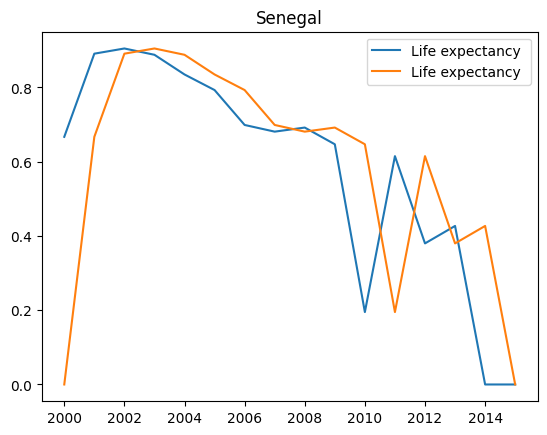

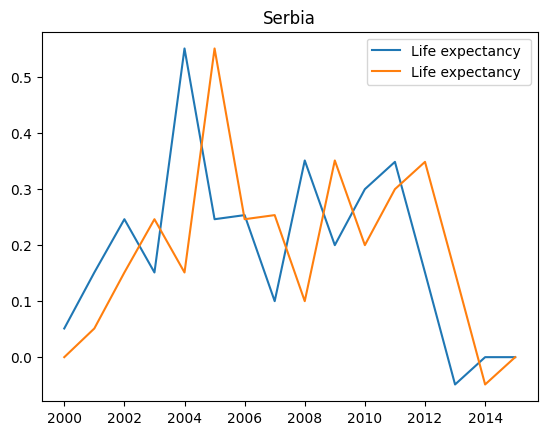

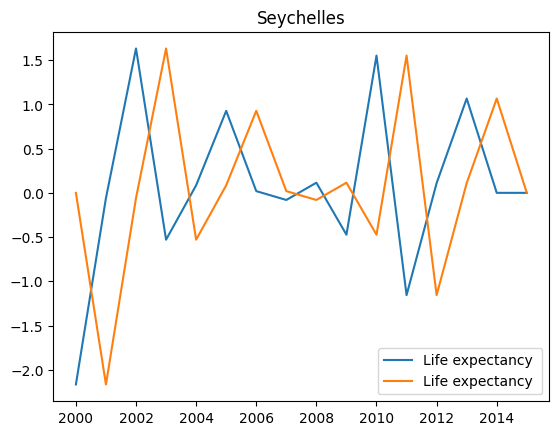

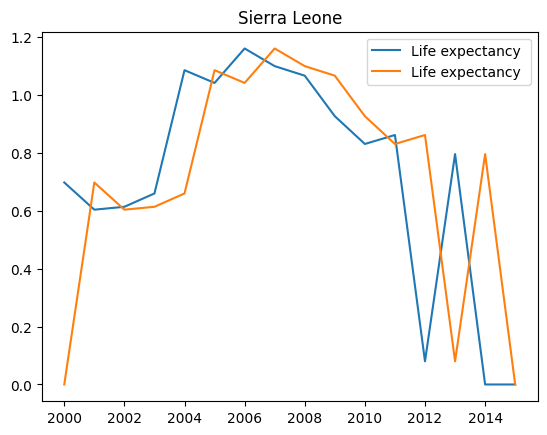

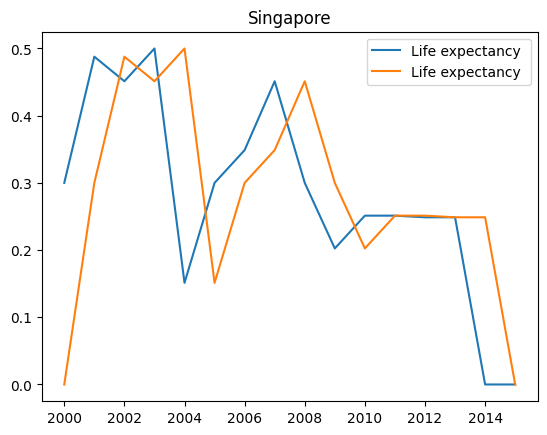

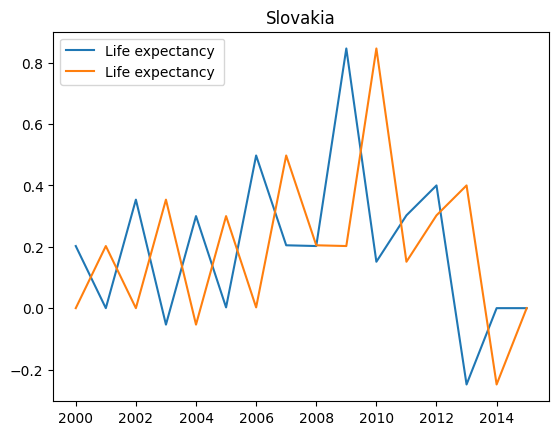

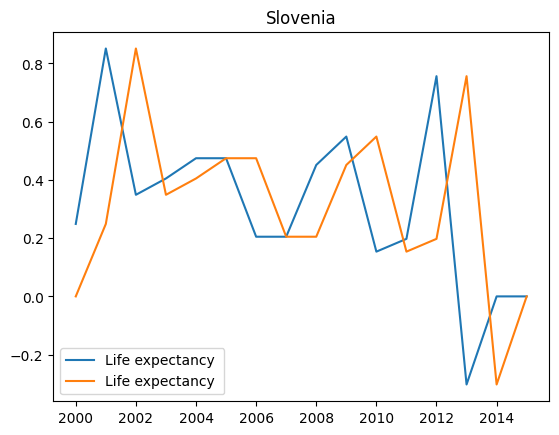

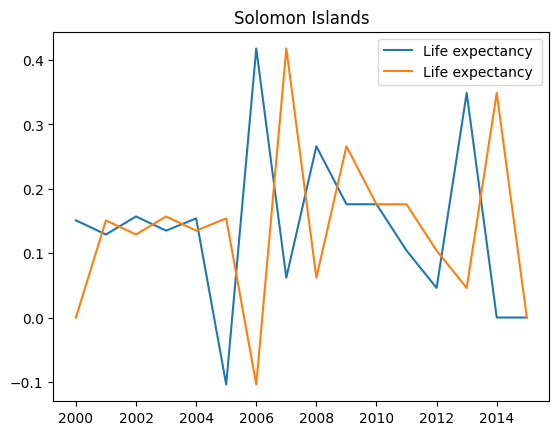

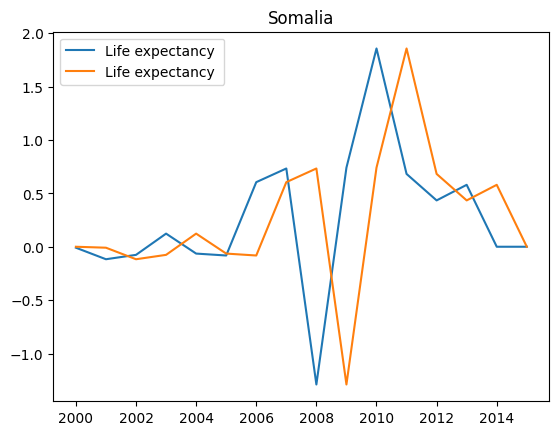

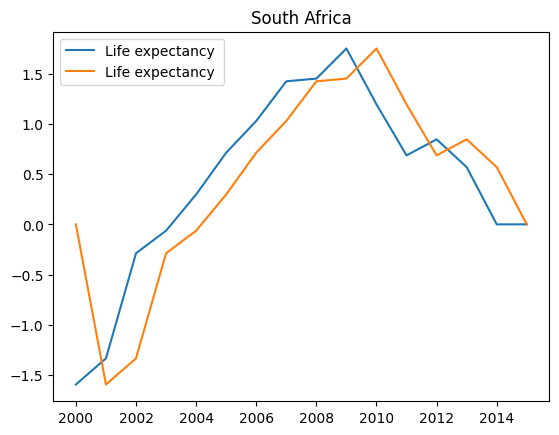

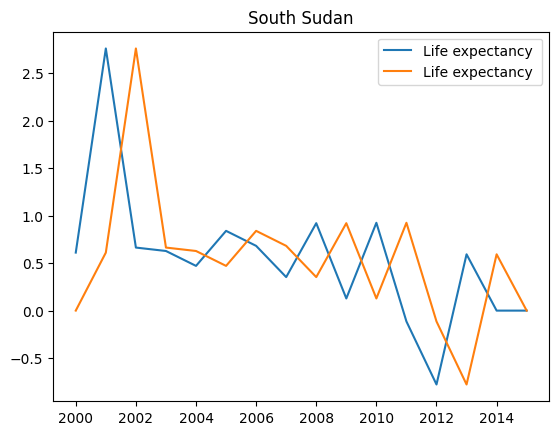

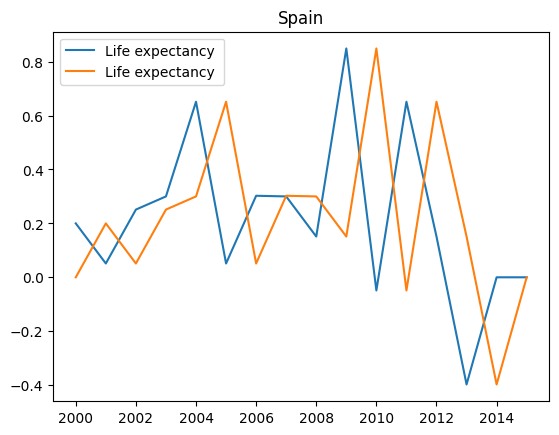

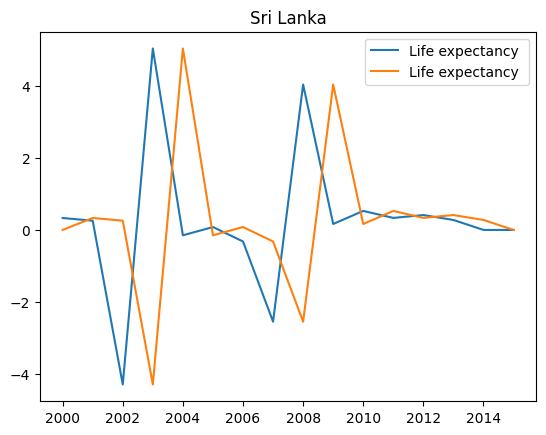

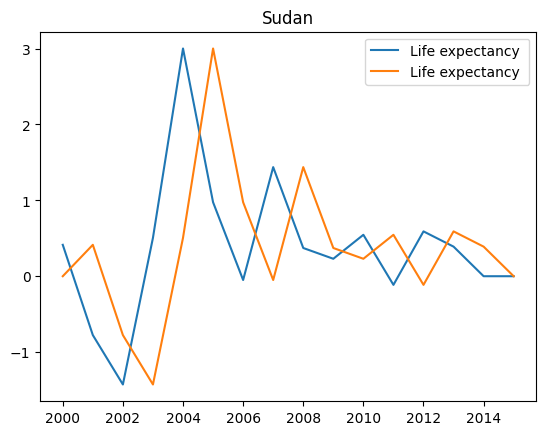

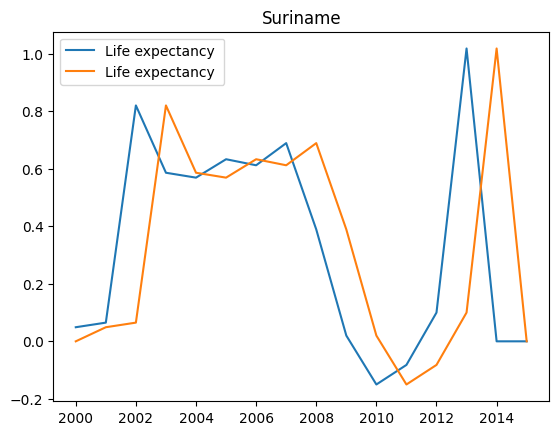

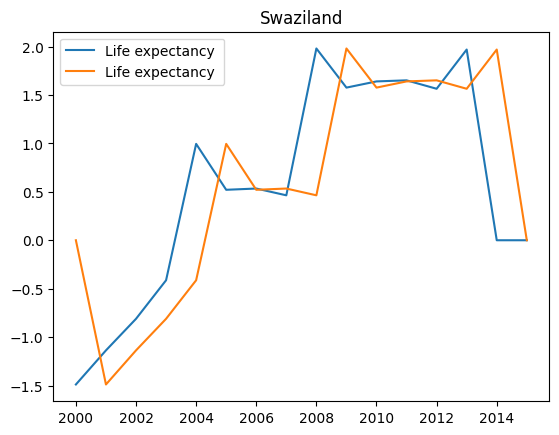

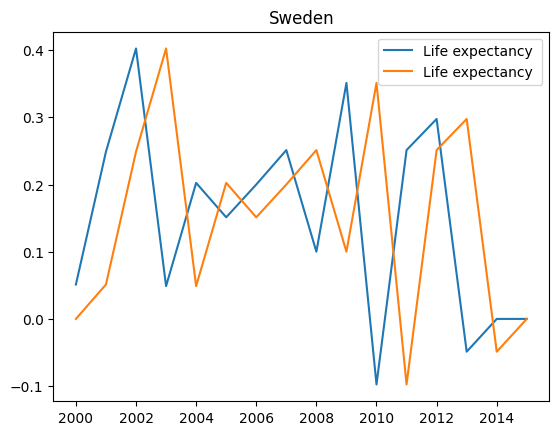

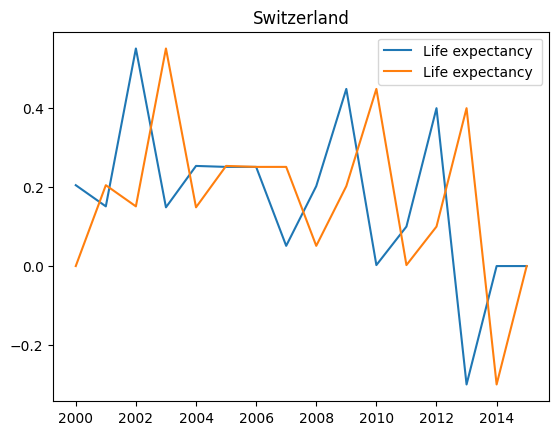

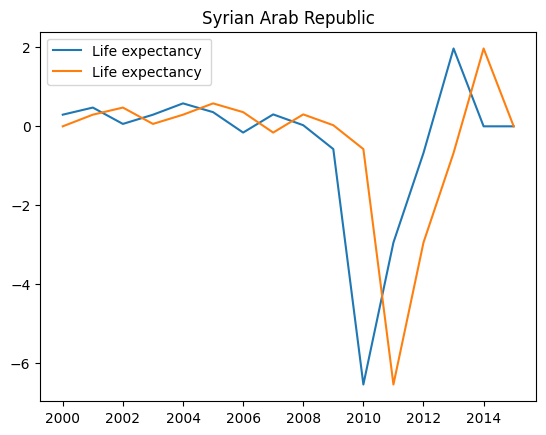

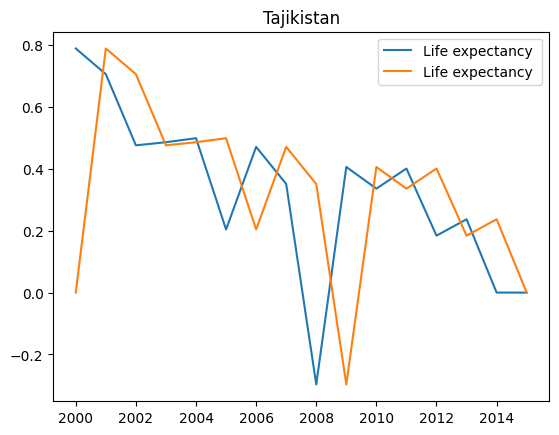

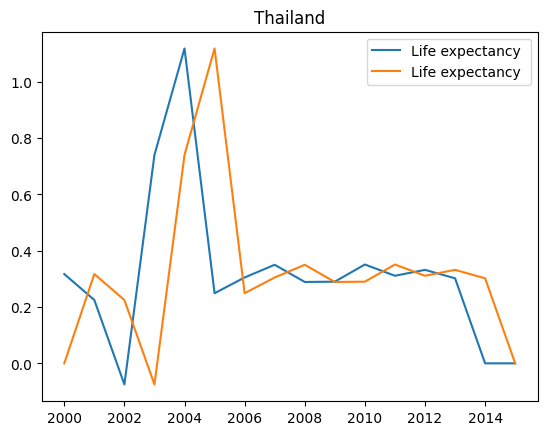

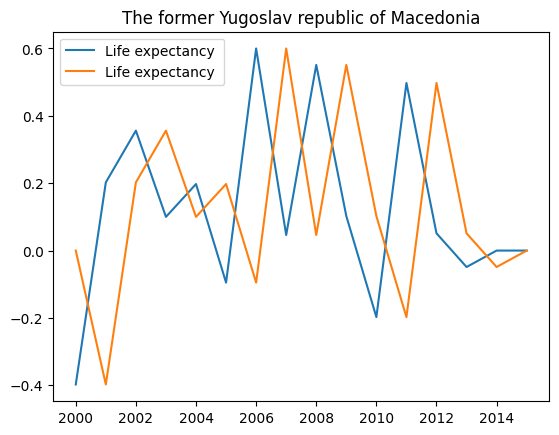

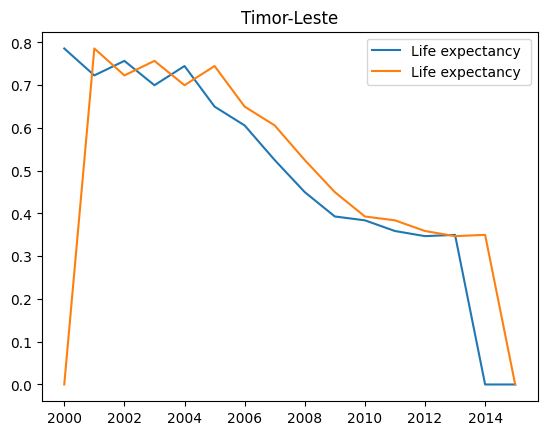

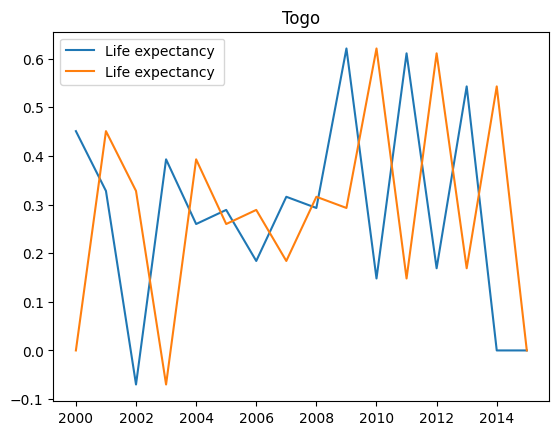

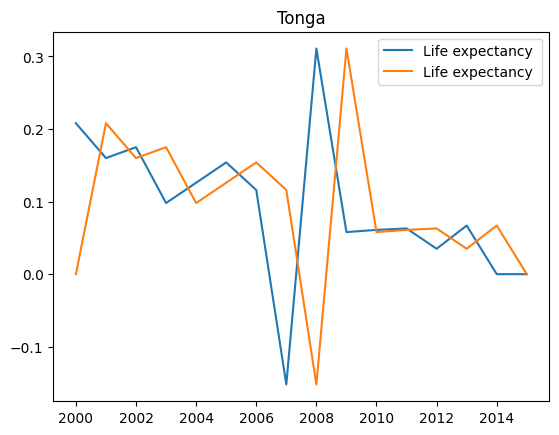

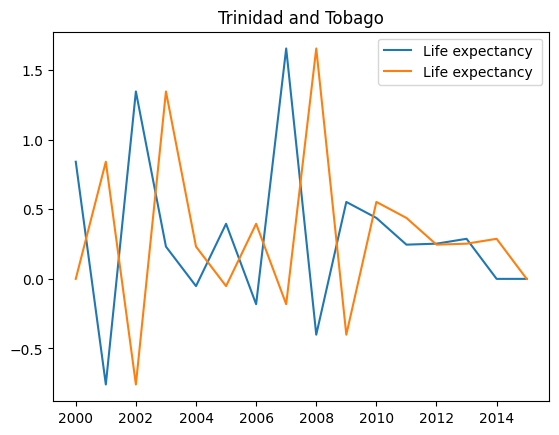

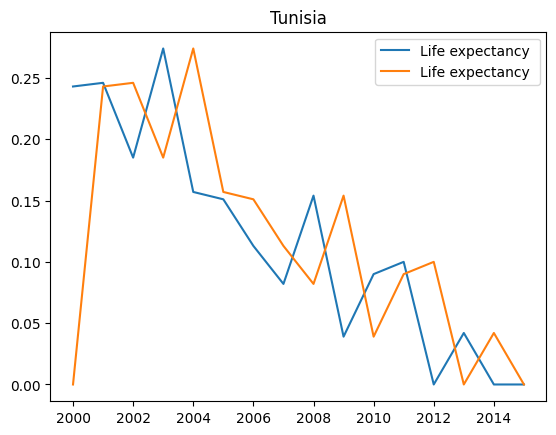

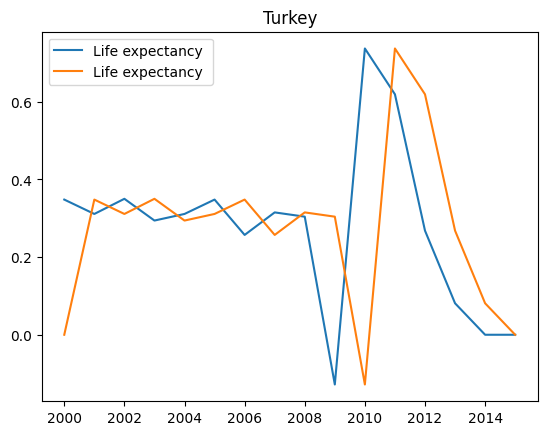

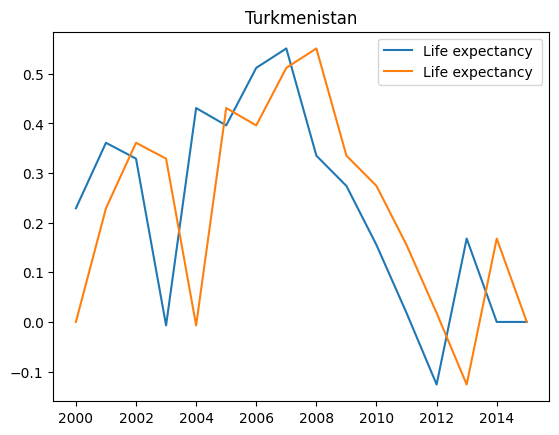

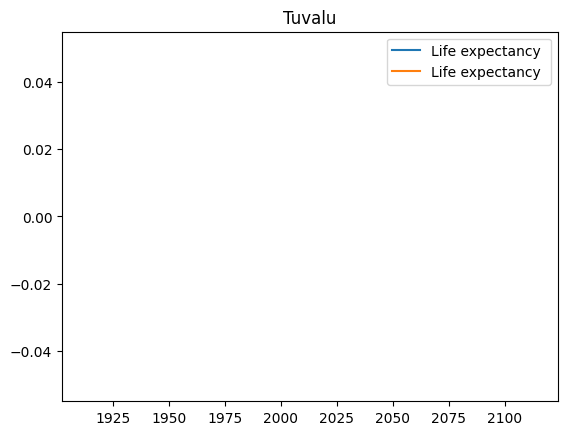

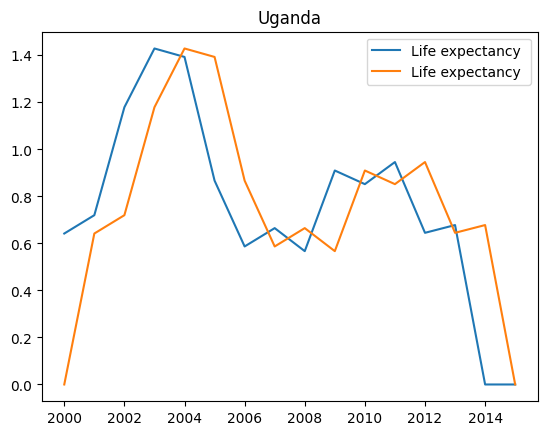

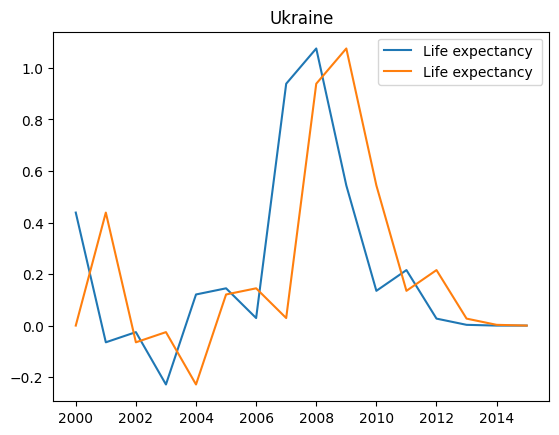

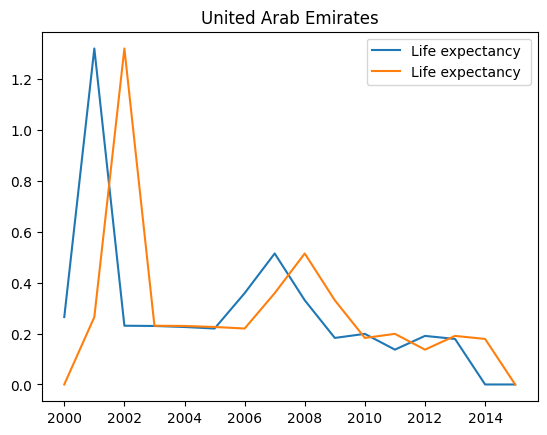

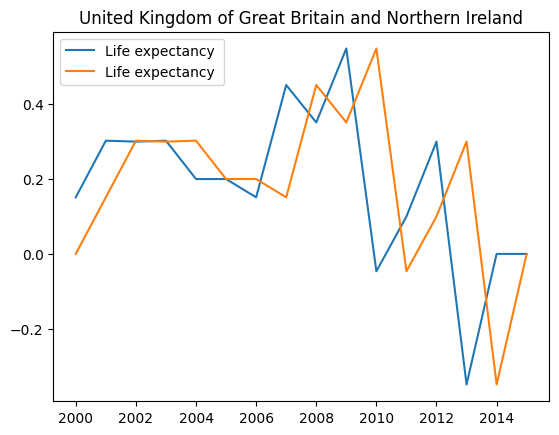

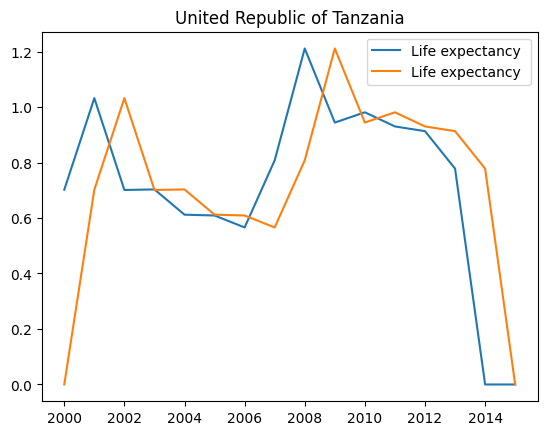

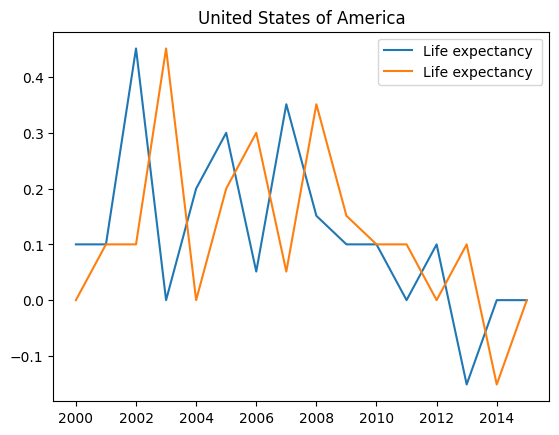

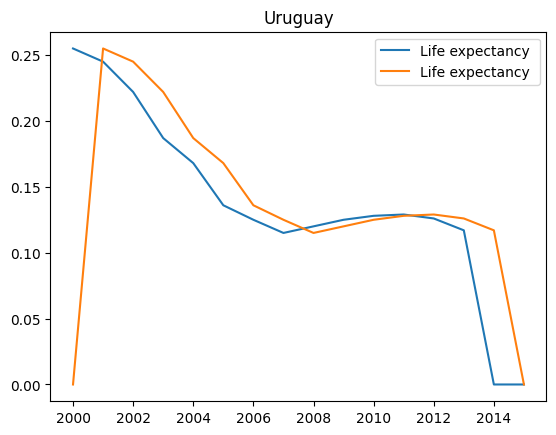

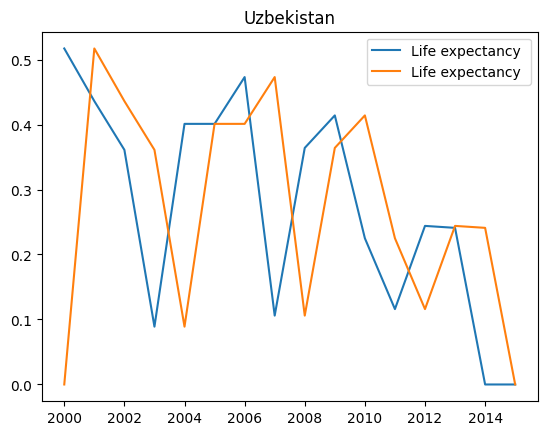

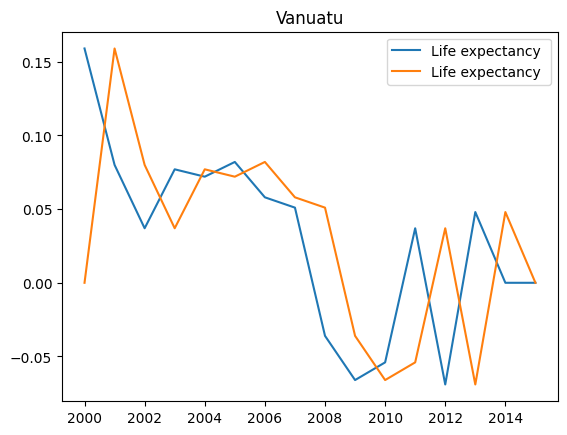

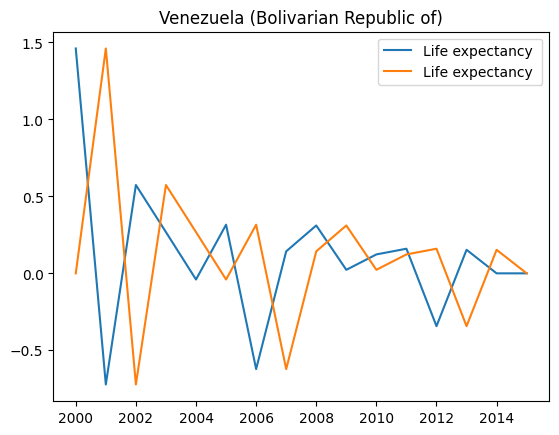

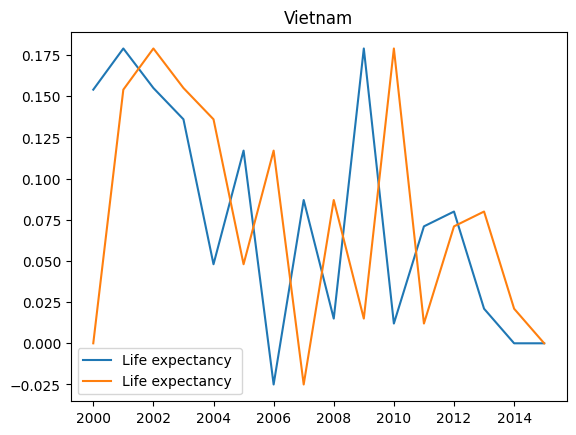

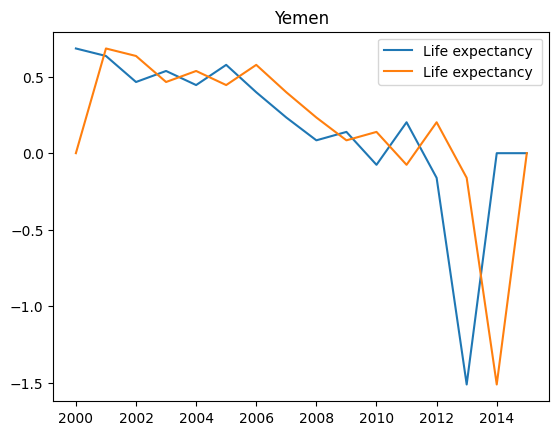

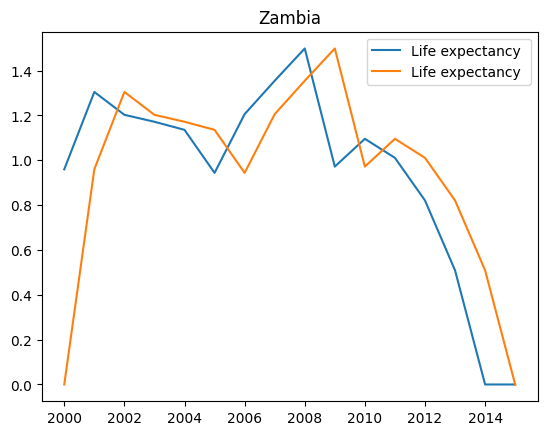

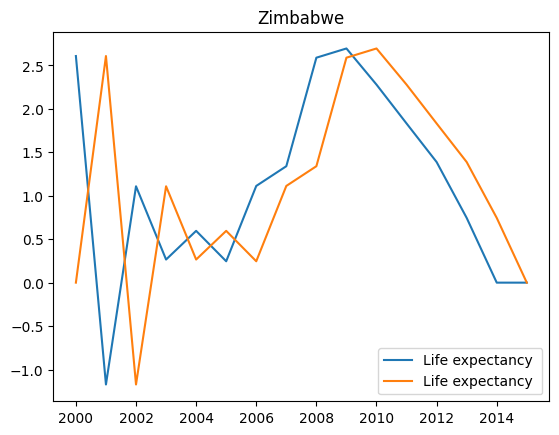

In [28]:
train_split = data[data['Year'] < 2010]
test_split = data[data['Year'] >= 2012]
test_split = test_split[test_split['Year'] < 2014]
val_split = data[data['Year'] >= 2014]

# make list of all columns that need to be standardized
cols = train_split.columns
cols = cols.drop(['Country', 'continent', 'Year', 'Status'])
# standardize all columns except country, continent, year and status
for col in cols:
    if col not in ['Country', 'continent', 'Year', 'Status']:
        mean = train_split[col].mean()
        std = train_split[col].std()
        train_split[col] = (train_split[col] - mean) / std
        test_split[col] = (test_split[col] - mean) / std
        val_split[col] = (val_split[col] - mean) / std

# plot life expectancy for each country
for i, country in enumerate(data['Country'].unique()):
    d = data[data['Country'] == country]
    plt.plot(d['Year'], d['Life expectancy difference'], label='Life expectancy ')
    plt.plot(d['Year'], d['Life expectancy difference 1 year ago'], label='Life expectancy ')
    plt.title(country)
    plt.legend()
    plt.show()

In [27]:
# Fit linear model:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# make new data without target variable
cols = cols.drop(['Life expectancy difference', 'Life expectancy '])

# fit a regression model to predict the difference in life expectancy
reg = LinearRegression().fit(train_split[cols], train_split['Life expectancy difference'])
# predict the difference in life expectancy for the test set
y_pred = reg.predict(test_split[cols])

# calculate the mean squared error
mse = mean_squared_error(test_split['Life expectancy difference'], y_pred)
print('Mean squared error: ', mse)

for i, col in enumerate(cols):
    print(col, reg.coef_[i])

# compare with baseline model that always predicts average of train data label
y_pred_baseline = np.ones(len(test_split)) * train_split['Life expectancy difference'].mean()
mse_baseline = mean_squared_error(test_split['Life expectancy difference'], y_pred_baseline)
print('Mean squared error baseline: ', mse_baseline)



Mean squared error:  0.5122587290758058
infant deaths -0.2580941804223975
Alcohol -0.0009879414950542398
Hepatitis B -0.025071728797173638
MeaslesPrMillion -0.019350621492994866
OverweightOfAdults% -0.06943256561600773
Polio 0.014516256410017988
Total expenditure -0.011389167130946383
Diphtheria  0.015995912242782965
 HIV/AIDS -0.24020289023484695
GDP 0.0059530059134692325
Population 0.04731206889746831
 thinness  1-19 years -0.004377862222644706
Schooling 0.003716160332247154
WaterFacility 0.011463891995138403
WomenInParlament 0.006666633831412936
Life expectancy difference 1 year ago -0.35000858944033236
Life expectancy difference 2 years ago -0.01844651570420812
Mean squared error baseline:  0.533577449151713
